# 第 3 章：图驱动的 AI 智能体系统

> 本笔记文件需要与《LangGraph实战》的第 3 章的内容配套使用。

我们习惯于用线性的、因果的视角去理解世界，如同手持一张粗略的地图，在一条条
既定的道路上按部就班地前行。然而，真实的疆域远比地图复杂，它充满了未知的岔
路、突发的状况，以及无数交织的可能性。当我们试图构建能够理解、适应并驾驭这
个复杂世界的 AI 智能体时，线性的思维模式便显得捉襟见肘。**图**，正是这样一
种活地图，它超越了线性结构的局限，以节点和边构建起一个充满可能性的网络，让
我们得以描绘智能体系统中那些非线性的、动态的、错综复杂的行为路径。

本章将深入探讨 LangGraph 的图计算模型，学习如何利用状态、节点、边、命令这
四个核心原语构建复杂的智能体系统，掌握并行处理、MapReduce模式、子图机制等
高级技术，最终构建出能够应对真实世界复杂挑战的智能体应用。

### 🚀 环境准备

首先加载必要的环境变量配置：

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## 3.1 核心原语：状态、节点、边和命令

LangGraph 的核心在于其简洁而强大的图计算模型，这一模型的基石由四个核心原语构成：**状态（State）**、**节点（Node）**、**边（Edge）**，以及**命令（Command）**。

理解这四个原语的概念及其相互作用方式，是掌握 LangGraph 并构建复杂智能体系统的重中之重。可以将这四个原语比作乐高积木最基本的、也是最核心的模块，理解了它们，就如同掌握了乐高搭建的"语言"，后续才能使用更高级的技巧，搭建出各种各样精巧、复杂、功能强大的智能体系统。

### 3.1.1 状态（State）

在 LangGraph 中，状态是贯穿智能体系统运行始终的核心概念。我们可以将其理解为智能体的"短期记忆"、"工作记忆"或者"临时共享数据空间"，它承载着智能体在执行过程中产生的各种信息，例如用户的输入、中间计算结果、工具的输出、对话历史等等。

LangGraph 在状态定义上提供了极大的灵活性，允许开发者根据实际应用的需求，选择最合适的数据结构来表示状态。

##### 示例 3-1：使用 TypedDict 和 Pydantic 定义状态

In [2]:
from typing_extensions import TypedDict
from pydantic import BaseModel, field_validator

# 使用 TypedDict 定义状态
class TypedDictState(TypedDict):
    user_input: str
    agent_response: str
    tool_output: str

# 使用 Pydantic 定义状态，并进行数据验证
class PydanticState(BaseModel):
    user_input: str
    agent_response: str
    tool_output: str
    mood: str = "neutral"  # 默认情绪状态为 neutral

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        if value not in ["happy", "sad", "neutral"]:
            raise ValueError("情绪状态必须是 'happy', 'sad' 或 'neutral'")
        return value

# 测试状态定义
print("TypedDict 状态示例:")
typed_state = {"user_input": "Hello", "agent_response": "Hi there!", "tool_output": "weather data"}
print(typed_state)

print("\nPydantic 状态示例:")
pydantic_state = PydanticState(
    user_input="Hello", 
    agent_response="Hi there!", 
    tool_output="weather data",
    mood="happy"
)
print(pydantic_state.model_dump())

TypedDict 状态示例:
{'user_input': 'Hello', 'agent_response': 'Hi there!', 'tool_output': 'weather data'}

Pydantic 状态示例:
{'user_input': 'Hello', 'agent_response': 'Hi there!', 'tool_output': 'weather data', 'mood': 'happy'}


**💡 核心概念解析**：

- **TypedDict**：可以快速定义简单的状态结构，提供类型提示但不进行运行时验证
- **Pydantic**：提供更强大的数据建模和验证能力，能够在运行时进行数据验证，确保状态的类型和取值符合预期
- **状态的作用**：作为各节点间信息传递的桥梁，也是智能体进行决策和行为调整的重要依据

##### 示例 3-2：使用多结构体实现私有状态

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
import json

# 定义全局的公共状态 Schema
class OverallState(TypedDict):
    user_input: str
    agent_response: str

# 定义节点的私有状态 Schema
class ToolState(TypedDict):
    api_key: str
    tool_config: dict
    user_input: str  # 需要包含从公共状态传递的数据

# 模拟 API 客户端类
class MockAPIClient:
    def __init__(self, api_key: str, config: dict):
        self.api_key = api_key
        self.config = config
        print(f"初始化 API 客户端，API Key: {api_key[:8]}..., 配置: {config}")

    def call_api(self, user_input: str) -> str:
        # 模拟 API 调用
        response = f"基于输入 '{user_input}' 和配置 {self.config}，API 返回处理结果"
        print(f"调用 API，输入: {user_input}")
        return response

def create_api_client(api_key: str, tool_config: dict) -> MockAPIClient:
    """创建 API 客户端的工厂函数"""
    return MockAPIClient(api_key, tool_config)

# 定义一个使用私有状态的节点
def tool_node(state: ToolState) -> OverallState:
    """使用私有状态的工具节点"""
    print(f"工具节点接收到私有状态: {state}")

    # 节点逻辑，例如调用工具 API 并根据 ToolState 中的配置进行操作
    api_client = create_api_client(state['api_key'], state['tool_config'])
    response = api_client.call_api(state['user_input'])

    return {"agent_response": response}  # 返回更新后的公共状态

# 定义一个输入处理节点
def input_processor(state: OverallState) -> OverallState:
    """处理用户输入的节点"""
    print(f"输入处理节点接收到: {state['user_input']}")
    processed_input = f"已处理: {state['user_input']}"
    return {"user_input": processed_input}

# 定义状态适配节点，将公共状态转换为私有状态
def state_adapter(state: OverallState) -> dict:
    """适配器节点：将公共状态转换为私有状态"""
    from langgraph.constants import Send

    # 创建私有状态数据
    private_state = {
        "api_key": "secret_api_key_12345",
        "tool_config": {
            "timeout": 30,
            "retry_count": 3,
            "endpoint": "https://api.example.com"
        },
        "user_input": state["user_input"]
    }

    # 使用 Send 将私有状态发送给工具节点
    return Send("tool_node", private_state)

# 构建图
builder = StateGraph(OverallState)

# 添加节点
builder.add_node("input_processor", input_processor)
builder.add_node("state_adapter", state_adapter)
builder.add_node("tool_node", tool_node)

# 定义边
builder.add_edge(START, "input_processor")
builder.add_conditional_edges("input_processor", state_adapter, ["tool_node"])
builder.add_edge("tool_node", END)

# 编译图
graph = builder.compile()

# 测试运行
print("=== 多结构体状态管理示例 ===\n")

# 初始状态
initial_state = {
    "user_input": "查询天气信息",
    "agent_response": ""
}

print(f"初始状态: {initial_state}\n")

# 运行图
try:
    final_state = graph.invoke(initial_state)
    print(f"\n最终状态: {final_state}")

    print(f"\n=== 执行结果 ===")
    print(f"用户输入: {final_state['user_input']}")
    print(f"智能体响应: {final_state['agent_response']}")

except Exception as e:
    print(f"执行出错: {e}")

=== 多结构体状态管理示例 ===

初始状态: {'user_input': '查询天气信息', 'agent_response': ''}

输入处理节点接收到: 查询天气信息
工具节点接收到私有状态: {'api_key': 'secret_api_key_12345', 'tool_config': {'timeout': 30, 'retry_count': 3, 'endpoint': 'https://api.example.com'}, 'user_input': '已处理: 查询天气信息'}
初始化 API 客户端，API Key: secret_a..., 配置: {'timeout': 30, 'retry_count': 3, 'endpoint': 'https://api.example.com'}
调用 API，输入: 已处理: 查询天气信息

最终状态: {'user_input': '已处理: 查询天气信息', 'agent_response': "基于输入 '已处理: 查询天气信息' 和配置 {'timeout': 30, 'retry_count': 3, 'endpoint': 'https://api.example.com'}，API 返回处理结果"}

=== 执行结果 ===
用户输入: 已处理: 查询天气信息
智能体响应: 基于输入 '已处理: 查询天气信息' 和配置 {'timeout': 30, 'retry_count': 3, 'endpoint': 'https://api.example.com'}，API 返回处理结果


/var/folders/f3/zw7t8v4s6j3gd6hyktrdg85r0000gn/T/ipykernel_61919/1411650879.py:54: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


这个完整的示例展示了：

1. 多结构体定义：
  - `OverallState`：全局公共状态，包含用户输入和智能体响应
  - `ToolState`：私有状态，包含 API 密钥、工具配置和用户输入
2. 状态转换机制：
  - `state_adapter` 节点负责将公共状态转换为私有状态
  - 使用 Send API 将私有状态发送给特定节点
3. 私有状态的使用：
  - `tool_node` 接收私有状态，包含敏感信息（API 密钥、配置）
  - 节点处理完成后返回公共状态格式的更新
4. 完整的工作流：
  - 输入处理 → 状态适配 → 工具调用 → 结果返回

##### 示例 3-3：定义输入/输出结构体

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# 定义内部的、全面的状态结构体
class InternalState(TypedDict):
    user_query: str
    search_results: list[str]
    llm_response: str
    debug_info: str  # 内部调试信息，不需要对外暴露

# 定义输入结构体 (只包含 user_query)
class InputSchema(TypedDict):
    user_query: str

# 定义输出结构体 (只包含 llm_response)
class OutputSchema(TypedDict):
    llm_response: str

# 模拟搜索节点
def search_node(state: InternalState) -> InternalState:
    query = state["user_query"]
    print(f"🔍 搜索节点: 处理查询 '{query}'")

    # 模拟搜索结果
    mock_results = [
        f"搜索结果1: 关于 '{query}' 的信息",
        f"搜索结果2: {query} 相关数据",
        f"搜索结果3: {query} 详细说明"
    ]

    debug = f"搜索完成，找到 {len(mock_results)} 条结果"
    print(f"📊 {debug}")

    return {
        "search_results": mock_results,
        "debug_info": debug
    }

# LLM 处理节点
def llm_node(state: InternalState) -> InternalState:
    query = state["user_query"]
    results = state["search_results"]

    print(f"🤖 LLM 节点: 基于 {len(results)} 条搜索结果生成回复")

    # 模拟 LLM 生成响应
    combined_info = " | ".join(results[:2])  # 使用前两条结果
    response = f"基于您的查询 '{query}'，我找到了以下信息：{combined_info}。希望这能帮到您！"

    debug = f"LLM 处理完成，生成 {len(response)} 字符的回复"
    print(f"💭 {debug}")
    print(f"📝 生成回复: {response[:50]}...")

    return {
        "llm_response": response,
        "debug_info": state.get("debug_info", "") + f" | {debug}"
    }

# 创建图并指定输入输出结构体
print("🏗️ 构建 LangGraph（带输入输出结构体约束）...")
builder = StateGraph(InternalState, input=InputSchema, output=OutputSchema)

# 添加节点
builder.add_node("search", search_node)
builder.add_node("llm", llm_node)

# 定义边
builder.add_edge(START, "search")
builder.add_edge("search", "llm")
builder.add_edge("llm", END)

# 编译图
graph = builder.compile()
print("✅ 图构建完成！")

# 测试运行
print("\n=== 🚀 输入输出结构体约束示例 ===")

# 创建符合 InputSchema 的输入
input_data = {"user_query": "什么是人工智能"}
print(f"📥 输入数据 (InputSchema): {input_data}")

# 运行图
result = graph.invoke(input_data)

# 结果自动符合 OutputSchema 格式
print(f"\n📤 输出数据 (OutputSchema): {result}")
print(f"📊 输出类型: {type(result)}")
print(f"📋 输出键: {list(result.keys())}")

🏗️ 构建 LangGraph（带输入输出结构体约束）...
✅ 图构建完成！

=== 🚀 输入输出结构体约束示例 ===
📥 输入数据 (InputSchema): {'user_query': '什么是人工智能'}
🔍 搜索节点: 处理查询 '什么是人工智能'
📊 搜索完成，找到 3 条结果
🤖 LLM 节点: 基于 3 条搜索结果生成回复
💭 LLM 处理完成，生成 80 字符的回复
📝 生成回复: 基于您的查询 '什么是人工智能'，我找到了以下信息：搜索结果1: 关于 '什么是人工智能' 的信息 ...

📤 输出数据 (OutputSchema): {'llm_response': "基于您的查询 '什么是人工智能'，我找到了以下信息：搜索结果1: 关于 '什么是人工智能' 的信息 | 搜索结果2: 什么是人工智能 相关数据。希望这能帮到您！"}
📊 输出类型: <class 'dict'>
📋 输出键: ['llm_response']


/var/folders/f3/zw7t8v4s6j3gd6hyktrdg85r0000gn/T/ipykernel_61919/1444540557.py:61: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(InternalState, input=InputSchema, output=OutputSchema)
/var/folders/f3/zw7t8v4s6j3gd6hyktrdg85r0000gn/T/ipykernel_61919/1444540557.py:61: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(InternalState, input=InputSchema, output=OutputSchema)


1. 三层状态结构体：
  - `InternalState`：内部完整状态，包含所有中间数据
  - `InputSchema`：外部输入接口，只需要用户查询
  - `OutputSchema`：外部输出接口，只返回最终回复
2. 状态封装：
  - 内部节点可以访问和修改完整的内部状态
  - 外部只能看到定义的输入输出格式
  - 调试信息、搜索结果等中间数据被隐藏
3. 实际工作流程：
  - 搜索节点模拟信息检索
  - LLM 节点基于搜索结果生成回复
  - 完整的状态管理和数据流
4. 输入输出约束验证：
  - 输入只需要符合 `InputSchema`
  - 输出自动符合 `OutputSchema`
  - 内部复杂性被完全封装

#### 3.1.1.3 状态 Reducer 

状态 Reducer 是 LangGraph 提供的用于自定义状态更新逻辑的核心机制。它允许我们精细地控制状态在节点执行过程中的演变方式，尤其是在处理并发状态更新、复杂数据结构以及需要特定合并策略的场景下。

##### 示例 3-4：使用状态 Reducer

In [5]:
from typing_extensions import TypedDict, Annotated
from operator import add
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

# 定义状态 Schema，并为 'message_history' 键指定 add_messages Reducer
class ChatState(TypedDict):
    message_history: Annotated[list[BaseMessage], add_messages]
    user_intent: str
    tool_output: str

# 演示 add_messages Reducer 的工作方式
print("演示 add_messages Reducer：")

# 初始状态
initial_state = {
    "message_history": [HumanMessage(content="Hello")],
    "user_intent": "greeting",
    "tool_output": ""
}

print("初始状态:")
for msg in initial_state["message_history"]:
    print(f"  {type(msg).__name__}: {msg.content}")

# 新的消息更新
new_messages = [AIMessage(content="Hi there! How can I help you?")]
print("\n添加新消息:")
for msg in new_messages:
    print(f"  {type(msg).__name__}: {msg.content}")

# add_messages Reducer 会自动合并消息
updated_messages = add_messages(initial_state["message_history"], new_messages)
print("\n合并后的消息历史:")
for msg in updated_messages:
    print(f"  {type(msg).__name__}: {msg.content}")

演示 add_messages Reducer：
初始状态:
  HumanMessage: Hello

添加新消息:
  AIMessage: Hi there! How can I help you?

合并后的消息历史:
  HumanMessage: Hello
  AIMessage: Hi there! How can I help you?


##### 示例 3-5 & 3-6：自定义 Reducer 函数

In [6]:
def reducer_extend_unique(left: list[str] | None, right: list[str] | None) -> list[str]:
    """
    自定义 Reducer 函数，用于合并两个字符串列表，并进行去重
    """
    existing_items = left if left else []  # 如果 left 为 None，则初始化为空列表
    new_items = right if right else []     # 如果 right 为 None，则初始化为空列表
    combined_items = existing_items + new_items
    return list(set(combined_items))       # 使用 set 去重并转换为 list 返回

# 测试自定义 Reducer
print("测试自定义 Reducer：")

existing_list = ["apple", "banana", "orange"]
new_list = ["banana", "grape", "apple", "mango"]

print(f"已有列表: {existing_list}")
print(f"新增列表: {new_list}")

result = reducer_extend_unique(existing_list, new_list)
print(f"合并去重结果: {result}")

# 在状态结构体中应用自定义 Reducer
class ChatStateWithCustomReducer(TypedDict):
    message_history: Annotated[list[BaseMessage], add_messages]
    user_intent: str
    tool_output: str
    item_list: Annotated[list[str], reducer_extend_unique]  # 应用自定义 Reducer


测试自定义 Reducer：
已有列表: ['apple', 'banana', 'orange']
新增列表: ['banana', 'grape', 'apple', 'mango']
合并去重结果: ['banana', 'grape', 'orange', 'apple', 'mango']


#### 3.1.1.4 Message 与 MessagesState

在构建对话型 AI 智能体时，对话历史至关重要。LangGraph 引入了消息（Message）和 MessagesState 的概念，专门优化对话场景的状态管理。

LangChain 定义了多种消息类型：
- `HumanMessage`：代表人类用户的消息
- `AIMessage`：代表 AI 模型生成的消息
- `ToolMessage`：代表工具执行后的输出结果消息
- `SystemMessage`：代表系统发出的消息

##### 示例 3-7：使用 MessagesState 定义状态结构体

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage

class MyChatState(MessagesState):
    """
    自定义的 ChatState, 继承自 MessagesState, 
    自动包含 messages 状态键和 add_messages Reducer
    """
    user_intent: str
    tool_output: str
    # ... 可以添加其他自定义的状态键 ...

# 演示不同类型的消息
print("演示不同类型的消息：")

# 创建不同类型的消息
human_msg = HumanMessage(content="你好，我想查询今天的天气")
system_msg = SystemMessage(content="你是一个专业的天气助手，请友好地回复用户")
ai_msg = AIMessage(content="好的，我来帮你查询天气信息")
tool_msg = ToolMessage(content="北京今天晴转多云，温度 20-28°C", tool_call_id="weather_001")

messages = [system_msg, human_msg, ai_msg, tool_msg]

for i, msg in enumerate(messages, 1):
    print(f"{i}. {type(msg).__name__}: {msg.content}")

# 演示 MessagesState 的使用
print("\n演示 MessagesState 的状态管理：")
chat_state = {
    "messages": messages,
    "user_intent": "weather_query",
    "tool_output": "weather_data_retrieved"
}

print(f"对话轮次: {len(chat_state['messages'])}")
print(f"用户意图: {chat_state['user_intent']}")
print(f"工具输出: {chat_state['tool_output']}")

演示不同类型的消息：
1. SystemMessage: 你是一个专业的天气助手，请友好地回复用户
2. HumanMessage: 你好，我想查询今天的天气
3. AIMessage: 好的，我来帮你查询天气信息
4. ToolMessage: 北京今天晴转多云，温度 20-28°C

演示 MessagesState 的状态管理：
对话轮次: 4
用户意图: weather_query
工具输出: weather_data_retrieved


**💡 MessagesState 核心特性**：

- **内置 `messages` 状态键**：自动提供消息列表管理
- **默认 `add_messages` Reducer**：自动处理消息追加、更新和去重
- **消息序列化与反序列化**：支持 JSON 兼容的字典格式传递消息数据
- **可扩展性**：可以自由添加其他自定义状态键

##### 示例 3-8 & 3-9：在使用 MessagesState 的节点中使用 trim_messages 和 RemoveMessage

In [8]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, trim_messages, RemoveMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages.utils import count_tokens_approximately

llm = ChatOpenAI(model="Qwen/Qwen3-8B")

# 使用 trim_messages 的节点
def llm_node_with_trim(state: MessagesState):
    print("🤖 LLM节点 (使用 trim_messages)")
    message_history = state['messages']
    print(f"📥 接收到 {len(message_history)} 条消息")

    # 显示原始消息
    for i, msg in enumerate(message_history):
        content_preview = msg.content[:50] + "..." if len(msg.content) > 50 else msg.content
        print(f"  {i+1}. [{msg.__class__.__name__}] {content_preview}")

    # 使用 trim_messages 修剪消息历史
    trimmed_messages = trim_messages(
        message_history,
        max_tokens=200,  # 降低限制以便看到修剪效果
        strategy="last",
        token_counter=count_tokens_approximately,
        allow_partial=False
    )

    print(f"✂️ 修剪后保留 {len(trimmed_messages)} 条消息 (token限制: 200)")

    # 生成回复
    llm_response = llm.invoke(trimmed_messages)
    print(f"💭 生成回复: {llm_response.content}")

    return {"messages": [llm_response]}

# 使用 filter_messages 的节点 (基于 RemoveMessage)
def filter_node(state: MessagesState):
    print("\n🔧 过滤节点 (使用 RemoveMessage)")
    message_history = state['messages']
    print(f"📥 接收到 {len(message_history)} 条消息")

    remove_messages = []

    # 过滤策略：移除包含"你好"或"再见"的寒暄消息
    for msg in message_history:
        if any(greeting in msg.content.lower() for greeting in ["你好",
"再见", "hello", "bye"]):
            print(f"🗑️ 标记移除寒暄消息: {msg.content[:30]}...")
            remove_messages.append(RemoveMessage(id=msg.id))
        # 移除过长的消息
        elif len(msg.content) > 100:
            print(f"🗑️ 标记移除过长消息: {msg.content[:30]}...")
            remove_messages.append(RemoveMessage(id=msg.id))

    if remove_messages:
        print(f"📊 将移除 {len(remove_messages)} 条消息")
        return {"messages": remove_messages}
    else:
        print("✅ 没有需要移除的消息")
        return {}

# 添加用户消息的节点
def add_user_message(state: MessagesState):
    print("\n👤 添加用户消息节点")
    new_message = HumanMessage(content="我想了解人工智能的最新发展，特别是在自然语言处理方面的突破。")
    print(f"➕ 添加消息: {new_message.content}")
    return {"messages": [new_message]}

# 创建图
print("🏗️ 构建消息管理示例图...")
builder = StateGraph(MessagesState)

# 添加节点
builder.add_node("add_message", add_user_message)
builder.add_node("filter", filter_node)
builder.add_node("llm_trim", llm_node_with_trim)

# 定义边
builder.add_edge(START, "add_message")
builder.add_edge("add_message", "filter")
builder.add_edge("filter", "llm_trim")
builder.add_edge("llm_trim", END)

# 编译图
graph = builder.compile()
print("✅ 图构建完成！")

# 准备初始消息历史
print("\n=== 🚀 消息状态管理示例 ===")

initial_messages = [
    SystemMessage(content="你是一个专业的AI助手，擅长回答各种问题。"),
    HumanMessage(content="你好！很高兴见到你。"),
    AIMessage(content="你好！我也很高兴为您服务。有什么可以帮助您的吗？"),
    HumanMessage(content="这是一条很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长的测试消息，用来测试过滤功能。"),
    AIMessage(content="我明白了您的测试消息。"),
    HumanMessage(content="再见！"),
]

print("📋 初始消息历史:")
for i, msg in enumerate(initial_messages):
    content_preview = msg.content[:40] + "..." if len(msg.content) > 40 else msg.content
    print(f"  {i+1}. [{msg.__class__.__name__}] {content_preview}")

# 运行图
result = graph.invoke({"messages": initial_messages})

print(f"\n=== ✨ 最终结果 ===")
print(f"📊 最终消息历史包含 {len(result['messages'])} 条消息:")
for i, msg in enumerate(result['messages']):
    content_preview = msg.content[:50] + "..." if len(msg.content) > 50 else msg.content
    print(f"  {i+1}. [{msg.__class__.__name__}] {content_preview}")

🏗️ 构建消息管理示例图...
✅ 图构建完成！

=== 🚀 消息状态管理示例 ===
📋 初始消息历史:
  1. [SystemMessage] 你是一个专业的AI助手，擅长回答各种问题。
  2. [HumanMessage] 你好！很高兴见到你。
  3. [AIMessage] 你好！我也很高兴为您服务。有什么可以帮助您的吗？
  4. [HumanMessage] 这是一条很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长...
  5. [AIMessage] 我明白了您的测试消息。
  6. [HumanMessage] 再见！

👤 添加用户消息节点
➕ 添加消息: 我想了解人工智能的最新发展，特别是在自然语言处理方面的突破。

🔧 过滤节点 (使用 RemoveMessage)
📥 接收到 7 条消息
🗑️ 标记移除寒暄消息: 你好！很高兴见到你。...
🗑️ 标记移除寒暄消息: 你好！我也很高兴为您服务。有什么可以帮助您的吗？...
🗑️ 标记移除寒暄消息: 再见！...
📊 将移除 3 条消息
🤖 LLM节点 (使用 trim_messages)
📥 接收到 4 条消息
  1. [SystemMessage] 你是一个专业的AI助手，擅长回答各种问题。
  2. [HumanMessage] 这是一条很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长很长的测试消息，用来测试...
  3. [AIMessage] 我明白了您的测试消息。
  4. [HumanMessage] 我想了解人工智能的最新发展，特别是在自然语言处理方面的突破。
✂️ 修剪后保留 4 条消息 (token限制: 200)
💭 生成回复: 

以下是一些近期人工智能在自然语言处理（NLP）领域的重要突破和技术进展：

---

### **1. 大型语言模型（LLMs）的持续革新**
- **参数量与计算效率**：模型规模进一步扩大（如GPT-4、PaLM 2等），但训练和推理成本显著降低，软硬件协同优化（如MoE架构）使得模型在资源受限的环境下仍能保持高性能。
- **多语言能力**：模型支持更多语言（如低资源语言）的训练和推理，例如Meta的Llama系列、谷歌的Mistra等，推动了NLP在非英语场景的普及。
- **任

1. `trim_messages` 功能：
- 根据 Token 限制自动修剪消息历史
- 使用 `"last"` 策略保留最近的消息
- 模拟 Token 计数器进行 Token 估算
2. `filter_messages` (`RemoveMessage`) 功能：
- 根据内容规则过滤消息（移除寒暄语）
- 根据长度规则过滤消息（移除过长消息）
- 使用 `RemoveMessage` 标记要删除的消息
3. `MessagesState` 自动管理：
- 自动使用 `add_messages` Reducer
- 支持消息的添加和移除操作
- 维护完整的消息历史
4. 实际工作流程：
- 添加新的用户消息
- 过滤不需要的消息
- 使用修剪后的消息生成 LLM 回复
- 展示完整的消息管理流程

### 3.1.2 节点（Node）

节点是 LangGraph 图结构中的基本计算单元。每一个节点都封装了一个独立的计算逻辑，例如调用语言模型、执行工具、进行条件判断、或者仅仅是一个简单的数据处理函数。

在 LangGraph 中，节点本质上就是一个 Python 函数。这个函数接收当前的状态作为输入，并返回一个新的状态（或者状态的更新部分）作为输出。

##### 示例 3-10：节点函数的基本结构

In [9]:
def my_node(state):
    """
    节点函数示例
    """
    # 从状态中读取数据
    input_data = state.get("some_key", "default_value")
    
    # 执行节点计算逻辑
    def process_data(data):
        return f"处理后的数据: {data.upper()}"
    
    output_data = process_data(input_data)
    
    # 返回新的状态（或状态的更新部分）
    return {"some_key": output_data, "another_key": "new_value"}

# 测试节点函数
print("测试节点函数：")
test_state = {"some_key": "hello world", "existing_key": "existing_value"}
print(f"输入状态: {test_state}")

result = my_node(test_state)
print(f"节点输出: {result}")

# 模拟状态更新（LangGraph会自动处理状态合并）
updated_state = {**test_state, **result}
print(f"更新后状态: {updated_state}")

测试节点函数：
输入状态: {'some_key': 'hello world', 'existing_key': 'existing_value'}
节点输出: {'some_key': '处理后的数据: HELLO WORLD', 'another_key': 'new_value'}
更新后状态: {'some_key': '处理后的数据: HELLO WORLD', 'existing_key': 'existing_value', 'another_key': 'new_value'}


##### 示例 3-11：一个包含 LLM 节点的 LangGraph 图

In [10]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 定义状态结构体 
class ChatState(MessagesState):
    user_question: str  # 用户问题
    llm_response: str   # LLM回复

# 定义 LLM 节点 
def llm_node(state):
    prompt = ChatPromptTemplate.from_messages([
        ("human", "{question}")
    ])
    model = ChatOpenAI(model="Qwen/Qwen3-8B")
    chain = prompt | model
    
    response = chain.invoke({"question": state['user_question']}).content
    return {"llm_response": response}

# 构建图 
builder = StateGraph(ChatState)
builder.add_node("llm_node", llm_node)
builder.add_edge(START, "llm_node")
builder.add_edge("llm_node", END)
graph = builder.compile()

print("LangGraph 图构建完成")
print("节点: llm_node")
print("边: START -> llm_node -> END")

# 测试图的执行
print("\n测试图执行：")
try:
    result = graph.invoke({"user_question": "你好，LangGraph！"})
    print(f"执行结果: {result}")
except Exception as e:
    print(f"需要配置API密钥才能实际运行LLM: {e}")
    print("图结构已成功创建，可以在配置API后运行")

LangGraph 图构建完成
节点: llm_node
边: START -> llm_node -> END

测试图执行：
执行结果: {'messages': [], 'user_question': '你好，LangGraph！', 'llm_response': '\n\n你好！我是通义千问，很高兴认识你。LangGraph 是 LangChain 的一个扩展库，它提供了一种通过图结构来组织和操作数据的方式，使得构建更复杂的 AI 应用（如知识图谱、问答系统、推荐系统等）变得更加简单和高效。如果你有任何关于 LangGraph 的问题，或者需要帮助构建某个具体的应用，欢迎随时告诉我！'}


##### 示例 3-12：为 LangGraph 节点配置重试策略的代码示例

In [11]:
import operator
import sqlite3
import random
import time
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.pregel import RetryPolicy

# 模拟数据库类
class MockSQLDatabase:
    def __init__(self):
        self.connection_stable = False
        self.call_count = 0

    def run(self, query):
        self.call_count += 1
        print(f"🗄️ 数据库查询 (第{self.call_count}次): {query}")

        # 模拟不稳定的数据库连接 - 前2次调用会失败
        if self.call_count <= 2:
            print(f"❌ 数据库连接失败 (模拟错误)")
            raise sqlite3.OperationalError("数据库连接超时")

        print(f"✅ 数据库查询成功")
        return "艺术家数据: Van Gogh, Picasso, Da Vinci, Monet, Renoir"

# 模拟 LLM 类
class MockChatOpenAI:
    def __init__(self, model="mock-model"):
        self.model = model
        self.call_count = 0

    def invoke(self, messages):
        self.call_count += 1
        print(f"🤖 LLM调用 (第{self.call_count}次)")

        # 模拟 LLM 偶尔失败 - 30% 概率失败
        if random.random() < 0.3:
            print(f"❌ LLM服务暂时不可用 (模拟错误)")
            raise ConnectionError("LLM服务连接失败")

        last_message = messages[-1] if messages else None
        content = f"基于查询结果，我为您找到了相关的艺术家信息。这是第{self.call_count}次成功调用的响应。"
        print(f"✅ LLM响应生成成功")
        return AIMessage(content=content)

# 初始化模拟组件
db = MockSQLDatabase()
model = MockChatOpenAI(model="Mock-GPT-4")

# 定义图的状态
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

def query_database(state):
    """查询数据库节点 - 配置了特定异常重试"""
    print(f"\n📊 执行数据库查询节点...")
    query_result = db.run("SELECT * FROM Artist LIMIT 10;")
    return {"messages": [AIMessage(content=f"数据库查询结果: {query_result}")]}

def call_model(state):
    """调用模型节点 - 配置了最大重试次数"""
    print(f"\n🧠 执行模型调用节点...")
    response = model.invoke(state["messages"])
    return {"messages": [response]}

def user_input_node(state):
    """用户输入节点"""
    print(f"\n👤 添加用户输入...")
    user_message = HumanMessage(content="请帮我查询一些著名艺术家的信息")
    print(f"📝 用户问题: {user_message.content}")
    return {"messages": [user_message]}

# 定义图 builder
print("🏗️ 构建带重试策略的 LangGraph...")
builder = StateGraph(AgentState)

# 添加用户输入节点
builder.add_node("user_input", user_input_node)

# 为 call_model 节点配置重试策略: 最大重试 5 次，包含退避策略
builder.add_node(
    "model",
    call_model,
    retry=RetryPolicy(
        max_attempts=5,           # 最大重试5次
        initial_interval=0.5,     # 初始重试间隔0.5秒
        backoff_factor=2.0,       # 退避因子2.0 (指数退避)
        max_interval=8.0,         # 最大重试间隔8秒
        jitter=True              # 添加随机抖动
    )
)

# 为 query_database 节点配置重试策略: 针对 sqlite3.OperationalError 异常进行重试
builder.add_node(
    "query_database",
    query_database,
    retry=RetryPolicy(
        retry_on=sqlite3.OperationalError,  # 只对数据库操作错误重试
        max_attempts=4,                     # 最大重试4次
        initial_interval=1.0,               # 初始间隔1秒
        backoff_factor=1.5                  # 较小的退避因子
    )
)

# 定义边
builder.add_edge(START, "user_input")
builder.add_edge("user_input", "model")
builder.add_edge("model", "query_database")
builder.add_edge("query_database", END)

# 编译图
graph = builder.compile()
print("✅ 图构建完成！")

# 测试运行
print("\n=== 🚀 重试策略演示 ===")
print("📋 测试场景:")
print("  - 数据库节点: 前2次调用会失败，第3次成功")
print("  - 模型节点: 30% 概率失败，会自动重试")
print("  - 两个节点都配置了不同的重试策略\n")

try:
    # 运行图
    result = graph.invoke({"messages": []})

    print(f"\n=== ✨ 执行完成 ===")
    print(f"📊 最终消息数量: {len(result['messages'])}")
    for i, msg in enumerate(result['messages']):
        print(f"  {i+1}. [{msg.__class__.__name__}] {msg.content[:60]}...")

    print(f"\n=== 📈 重试统计 ===")
    print(f"🗄️ 数据库调用次数: {db.call_count}")
    print(f"🤖 模型调用次数: {model.call_count}")

except Exception as e:
    print(f"\n❌ 执行失败: {e}")
    print(f"🗄️ 数据库调用次数: {db.call_count}")
    print(f"🤖 模型调用次数: {model.call_count}")

ImportError: cannot import name 'RetryPolicy' from 'langgraph.pregel' (/Users/haili/workspaces/langgraph-in-action/.venv/lib/python3.13/site-packages/langgraph/pregel/__init__.py)

1. `RetryPolicy` 配置：
- `model` 节点：通用重试策略，处理各种异常
- `query_database` 节点：针对特定数据库异常的重试策略
2. 不同的重试参数：
- 最大重试次数、初始间隔、退避因子等
- 展示指数退避和抖动机制
3. 模拟失败场景：
- 数据库连接不稳定（前几次必然失败）
- LLM 服务偶尔不可用（随机失败）
4. 重试效果演示：
- 显示每次重试的过程
- 统计实际调用次数
- 展示重试策略的实际效果

### 3.1.3 边（Edge）

边在 LangGraph 中负责连接不同的节点，定义智能体系统的执行流程。边决定了在执行完一个节点之后，下一步应该执行哪个节点。

LangGraph 主要支持两种类型的边：
- **普通边**：定义节点间固定的、无条件的连接关系
- **条件边**：提供基于状态动态路由的能力

##### 示例 3-13：意图识别与技能路由流程

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

# 定义状态
class IntentState(TypedDict):
    user_input: str
    user_intent: str
    response: str

# 意图识别节点
def intent_recognition_node(state):
    user_input = state['user_input'].lower()
    
    # 简单的意图识别逻辑
    if '天气' in user_input or 'weather' in user_input:
        intent = "查询天气"
    elif '机票' in user_input or 'flight' in user_input:
        intent = "预订机票"
    elif '投诉' in user_input or 'complaint' in user_input:
        intent = "投诉建议"
    else:
        intent = "未知"
    
    return {"user_intent": intent}

# 技能节点
def weather_query_node(state):
    return {"response": "今天天气晴朗，温度 22-28°C"}

def flight_booking_node(state):
    return {"response": "为您查找合适的机票选项..."}

def complaint_suggestion_node(state):
    return {"response": "感谢您的反馈，我们会认真处理您的建议"}

# 条件路由函数
def route_to_skill(state):
    """条件函数，根据用户意图路由到不同的技能节点"""
    user_intent = state['user_intent']
    if user_intent == "查询天气":
        return "weather_query_node"  # 跳转到查询天气节点
    elif user_intent == "预订机票":
        return "flight_booking_node"  # 跳转到预订机票节点
    elif user_intent == "投诉建议":
        return "complaint_suggestion_node"  # 跳转到投诉建议处理节点
    else:
        return END  # 无法识别意图，结束流程

# 构建图
builder = StateGraph(IntentState)

# 添加节点
builder.add_node("intent_recognition_node", intent_recognition_node)
builder.add_node("weather_query_node", weather_query_node)
builder.add_node("flight_booking_node", flight_booking_node)
builder.add_node("complaint_suggestion_node", complaint_suggestion_node)

# 添加边
builder.add_edge(START, "intent_recognition_node")
builder.add_conditional_edges(
    "intent_recognition_node", 
    route_to_skill,
    ["weather_query_node", "flight_booking_node", "complaint_suggestion_node", END]
)
builder.add_edge("weather_query_node", END)
builder.add_edge("flight_booking_node", END)
builder.add_edge("complaint_suggestion_node", END)

# 编译图
intent_graph = builder.compile()

print("意图识别与技能路由图构建完成")

# 测试不同的用户输入
test_inputs = [
    "今天天气怎么样？",
    "我要预订明天到北京的机票",
    "我要投诉你们的服务",
    "你好"
]

for user_input in test_inputs:
    print(f"\n用户输入: {user_input}")
    result = intent_graph.invoke({"user_input": user_input})
    print(f"识别意图: {result.get('user_intent', '未识别')}")
    print(f"系统回复: {result.get('response', '无回复')}")

意图识别与技能路由图构建完成

用户输入: 今天天气怎么样？
识别意图: 查询天气
系统回复: 今天天气晴朗，温度 22-28°C

用户输入: 我要预订明天到北京的机票
识别意图: 预订机票
系统回复: 为您查找合适的机票选项...

用户输入: 我要投诉你们的服务
识别意图: 投诉建议
系统回复: 感谢您的反馈，我们会认真处理您的建议

用户输入: 你好
识别意图: 未知
系统回复: 无回复


**💡 边的类型和应用场景**：

- **条件边**：`add_conditional_edges()` 实现动态路由，根据运行时状态选择路径
- **普通边**：`add_edge()` 创建固定连接，适用于确定的流程序列
- **应用场景**：意图识别、工具选择、错误处理、流程分支等

### 3.1.4 命令（Command）

命令（Command）是 LangGraph 新推出的强大工具，它允许我们将状态更新和流程控制逻辑整合到同一个节点中。Command 打破了节点和边功能上的传统分工，赋予了节点更强大的流程控制能力。

一个 `Command` 对象主要包含以下两个部分：
- `update`（状态更新）：指定需要更新的状态键值对
- `goto`（流程跳转）：指定下一步要执行的节点名称

##### 示例 3-15：使用 Command 的节点函数

In [ ]:
from langgraph.types import Command
from typing import Literal
from typing_extensions import TypedDict

# 定义状态
class CommandState(TypedDict):
    input_data: str
    processed_data: str
    decision_result: str

def decide_next_node(state):
    """根据状态决定下一个节点"""
    input_data = state['input_data'].lower()
    if 'process_a' in input_data:
        return 'node_a'
    elif 'process_b' in input_data:
        return 'node_b'
    else:
        return 'node_c'

def decision_node(state) -> Command[Literal["node_a", "node_b", "node_c"]]:
    """
    使用 Command 的节点函数示例
    """
    # 处理输入数据
    input_data = state['input_data']
    processed_result = f"已处理: {input_data}"
    
    # 决定下一个节点
    next_node_name = decide_next_node(state)
    
    return Command(
        update={"processed_data": processed_result, "decision_result": f"决定跳转到: {next_node_name}"},  # 状态更新
        goto=next_node_name  # 流程跳转指令
    )

# 目标节点
def node_a(state):
    return {"processed_data": state['processed_data'] + " -> 经过节点A处理"}

def node_b(state):
    return {"processed_data": state['processed_data'] + " -> 经过节点B处理"}

def node_c(state):
    return {"processed_data": state['processed_data'] + " -> 经过节点C处理"}

# 构建使用 Command 的图
builder = StateGraph(CommandState)

# 添加节点
builder.add_node("decision_node", decision_node)
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)

# 添加边
builder.add_edge(START, "decision_node")
builder.add_edge("node_a", END)
builder.add_edge("node_b", END)
builder.add_edge("node_c", END)

# 编译图
command_graph = builder.compile()

print("Command 示例图构建完成")

# 测试不同的输入
test_inputs = [
    "请执行 process_a 操作",
    "需要 process_b 处理",
    "其他类型的操作"
]

for input_data in test_inputs:
    print(f"\n输入数据: {input_data}")
    result = command_graph.invoke({"input_data": input_data})
    print(f"决策结果: {result.get('decision_result', '无')}")
    print(f"处理结果: {result.get('processed_data', '无')}")

Command 示例图构建完成

输入数据: 请执行 process_a 操作
决策结果: 决定跳转到: node_a
处理结果: 已处理: 请执行 process_a 操作 -> 经过节点A处理

输入数据: 需要 process_b 处理
决策结果: 决定跳转到: node_b
处理结果: 已处理: 需要 process_b 处理 -> 经过节点B处理

输入数据: 其他类型的操作
决策结果: 决定跳转到: node_c
处理结果: 已处理: 其他类型的操作 -> 经过节点C处理


**💡 Command 的核心价值**：

- **内聚性**：将状态更新和流程控制逻辑封装在同一个节点中
- **类型安全**：通过 `Literal` 类型提示确保跳转目标的正确性
- **可视化支持**：LangGraph 可以静态分析 Command 的类型提示生成准确的流程图
- **灵活性**：特别适合多智能体协作中的"交接"场景

## 3.2 流程控制：分支与并发

在上一节中，我们了解了 LangGraph 的核心原语：状态、节点、边和命令。有了这些原语，我们就可以构建简单的线性流程。但在实际的智能体系统中，流程往往不是简单的线性执行，而是会根据不同的情况和条件，出现分支、并行、循环等复杂的控制流。

本节我们将重点探讨 LangGraph 中的流程控制机制，特别是如何利用 LangGraph 实现并行分支 (Parallel Branching)，构建能够并发执行多个任务、提高系统效率的智能体系统。

在最简单的 LangGraph 流程中，我们使用普通边将节点串联起来，形成一条线性的执行路径。但线性流程有其局限性：

- **无法处理条件判断**：线性流程无法根据状态或外部条件，动态地选择不同的执行路径
- **无法实现并行执行**：线性流程只能串行地执行节点，无法同时执行多个独立的任务
- **效率较低**：对于一些可以并行处理的任务，线性流程的串行执行方式会浪费计算资源

为了克服这些局限性，LangGraph 提供了强大的流程控制机制，其中分支 (Branching) 和 并发 (Concurrency) 是核心要素。

### 3.2.1 并行分支：扇出 (Fan-out) 与扇入 (Fan-in)

LangGraph 实现并行分支的核心机制是扇出 (Fan-out) 和 扇入 (Fan-in)。

- **扇出 (Fan-out)**：从一个节点出发，同时触发多个下游节点，使得流程并行地向多个方向分支
- **扇入 (Fan-in)**：将多个并行分支的流程汇聚到一个共同的下游节点，实现并行流程的同步和汇合

要实现扇出，最简单的方式是为一个节点添加多个出边，将该节点同时连接到多个下游节点。当 LangGraph 执行到该节点时，会同时、并发地触发所有出边指向的下游节点。

##### 示例 3-16：扇出和扇入的完整并行分支流程

In [ ]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# 定义状态，使用 operator.add Reducer 处理并行分支的状态更新
class ParallelState(TypedDict):
    aggregate: Annotated[list, operator.add]

def node_a(state: ParallelState):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}

def node_b(state: ParallelState):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}

def node_c(state: ParallelState):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}

def node_d(state: ParallelState):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

# 构建并行分支图
builder = StateGraph(ParallelState)

# 添加节点
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)
builder.add_node("node_d", node_d)

# 添加边：实现扇出和扇入
builder.add_edge(START, "node_a")  # 从 START 到 node_a
builder.add_edge("node_a", "node_b")  # node_a 扇出到 node_b
builder.add_edge("node_a", "node_c")  # node_a 扇出到 node_c (实现扇出)
builder.add_edge("node_b", "node_d")  # node_b 扇入到 node_d
builder.add_edge("node_c", "node_d")  # node_c 扇入到 node_d (实现扇入)
builder.add_edge("node_d", END)  # node_d 到 END

# 编译图
parallel_graph = builder.compile()

print("并行分支图构建完成")
print("流程: START -> node_a -> (node_b, node_c 并行) -> node_d -> END")

# 执行并行分支流程
print("\n执行并行分支流程:")
result = parallel_graph.invoke({"aggregate": []})
print(f"\n最终结果: {result}")

并行分支图构建完成
流程: START -> node_a -> (node_b, node_c 并行) -> node_d -> END

执行并行分支流程:
Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']

最终结果: {'aggregate': ['A', 'B', 'C', 'D']}


**💡 并行分支核心概念解析**：

- **扇出效果**：节点 A 执行完后，同时触发节点 B 和 C，两个节点并发执行
- **扇入同步**：节点 D 必须等待节点 B 和 C 都执行完成后才开始执行，起到同步点作用
- **状态 Reducer**：使用 `operator.add` Reducer 确保并行分支的状态更新能正确合并
- **执行效率**：并行执行比串行执行节省时间，如果 B 需要 3 秒，C 需要 5 秒，并行执行总共只需 5 秒

可以看到执行结果中，节点 B 和 C 是并发执行的，然后节点 D 汇聚了两个分支的结果。

### 3.2.2 并发 (Concurrency) 而非并行 (Parallelism)

需要明确的是，LangGraph 实现的并非真正的并行 (Parallelism)，而是并发 (Concurrency)。理解这个区别对于正确使用 LangGraph 非常重要：

#### 并发 vs 并行的本质区别

- **并行 (Parallelism)**：同时执行多个独立的任务，需要多个物理计算资源（多核 CPU、多台机器）真正地同时运行不同的代码
- **并发 (Concurrency)**：在单计算资源上，"看似同时"执行多个任务，通过时间片轮转或异步 IO，CPU 在多个任务之间快速切换

#### LangGraph 的 Superstep 执行模型

LangGraph 借鉴了 Apache Pregel 分布式图计算框架的 Superstep (超步) 概念：

- **Superstep**：图执行的基本迭代单元，代表 LangGraph 图执行过程中的一个"步骤"
- **并发执行**：在每个 Superstep 中，LangGraph 会尽可能地并发执行所有"就绪"的节点
- **同步屏障**：当 Superstep 内的所有节点都执行完成后，进行全局同步，应用状态更新，进入下一个 Superstep

##### 示例 3-17 & 3-18：Superstep 执行模式演示

In [ ]:
import time
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
import operator

class SuperstepState(TypedDict):
    superstep_log: Annotated[list, operator.add]
    timestamp: str

def superstep_node_a(state: SuperstepState):
    print(f"Superstep 1: 执行节点 A")
    time.sleep(0.1)  # 模拟处理时间
    return {"superstep_log": ["Superstep 1: Node A executed"]}

def superstep_node_b(state: SuperstepState):
    print(f"Superstep 2: 执行节点 B (并发)")
    time.sleep(0.2)  # 模拟处理时间
    return {"superstep_log": ["Superstep 2: Node B executed"]}

def superstep_node_c(state: SuperstepState):
    print(f"Superstep 2: 执行节点 C (并发)")
    time.sleep(0.15)  # 模拟处理时间
    return {"superstep_log": ["Superstep 2: Node C executed"]}

def superstep_node_d(state: SuperstepState):
    print(f"Superstep 3: 执行节点 D (同步后)")
    time.sleep(0.1)  # 模拟处理时间
    return {"superstep_log": ["Superstep 3: Node D executed"]}

# 构建 Superstep 演示图
builder = StateGraph(SuperstepState)

# 添加节点
builder.add_node("superstep_a", superstep_node_a)
builder.add_node("superstep_b", superstep_node_b) 
builder.add_node("superstep_c", superstep_node_c)
builder.add_node("superstep_d", superstep_node_d)

# 添加边：演示 Superstep 执行
builder.add_edge(START, "superstep_a")          # Superstep 1: A 执行
builder.add_edge("superstep_a", "superstep_b")  # Superstep 2: A -> B (并发)
builder.add_edge("superstep_a", "superstep_c")  # Superstep 2: A -> C (并发) 
builder.add_edge("superstep_b", "superstep_d")  # Superstep 3: B -> D (同步)
builder.add_edge("superstep_c", "superstep_d")  # Superstep 3: C -> D (同步)
builder.add_edge("superstep_d", END)

superstep_graph = builder.compile()

print("Superstep 执行模式演示:")
print("Superstep 1: 执行 A")
print("Superstep 2: 并发执行 B 和 C (等待同步)")  
print("Superstep 3: 同步后执行 D")
print()

# 执行并记录时间
start_time = time.time()
result = superstep_graph.invoke({"superstep_log": []})
end_time = time.time()

print(f"\\n执行完成，总时间: {end_time - start_time:.3f} 秒")
print("执行日志:")
for log in result["superstep_log"]:
    print(f"  - {log}")

Superstep 执行模式演示:
Superstep 1: 执行 A
Superstep 2: 并发执行 B 和 C (等待同步)
Superstep 3: 同步后执行 D

Superstep 1: 执行节点 A
Superstep 2: 执行节点 B (并发)
Superstep 2: 执行节点 C (并发)
Superstep 3: 执行节点 D (同步后)
\n执行完成，总时间: 0.422 秒
执行日志:
  - Superstep 1: Node A executed
  - Superstep 2: Node B executed
  - Superstep 2: Node C executed
  - Superstep 3: Node D executed


**💡 Superstep 核心特性**：

- **并发性**：同一个 Superstep 内的多个节点可以并发执行，提高执行效率
- **同步性**：每个 Superstep 结束时有全局同步点，保证状态更新的原子性和一致性  
- **迭代性**：图执行是 Superstep 的迭代过程，每个 Superstep 在前一个基础上计算

从上面的例子可以看到：
- Superstep 1: 只有节点 A 执行
- Superstep 2: 节点 B 和 C 并发执行（等待较慢的任务完成）
- Superstep 3: 同步后节点 D 执行

总执行时间约等于每个 Superstep 中最慢节点的时间之和，而非所有节点时间的总和。

### 3.2.3 递归限制与并行分支

递归限制（Recursion Limit）用于限制 LangGraph 图执行过程中的最大 Superstep 迭代次数，防止图无限循环执行。

#### 重要特性

- **计数单位**：递归限制的计数单位是 Superstep，而不是节点
- **并行不影响计数**：无论一个 Superstep 内部并发执行了多少个节点，都只计为一次 Superstep 迭代
- **防止无限循环**：有效防止图陷入无限循环，保护计算资源

##### 示例 3-19：递归限制是对并行分支流程的限制

In [ ]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.errors import GraphRecursionError  # 导入 GraphRecursionError

class State(TypedDict):
    # operator.add 是状态归约器，确保状态键 aggregate 为 append-only 列表
    aggregate: Annotated[list, operator.add]

def node_a(state):
    print("🔄 执行节点 A")
    return {"aggregate": ["I'm A"]}

def node_b(state):
    print("🔄 执行节点 B")
    return {"aggregate": ["I'm B"]}

def node_c(state):
    print("🔄 执行节点 C")
    return {"aggregate": ["I'm C"]}

def node_d(state):
    print("🔄 执行节点 D")
    return {"aggregate": ["I'm D"]}

# 构建图
print("🏗️ 构建并行分支图...")
builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)
builder.add_node("d", node_d)

# 添加边 - 创建并行分支结构
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")  # 从 a 扇出到 b 和 c
builder.add_edge("b", "d")
builder.add_edge("c", "d")  # b 和 c 扇入到 d
builder.add_edge("d", END)

graph = builder.compile()
print("✅ 图构建完成！")

print("\n=== 递归限制和并行分支流程的限制 ===\n")

# 测试 1: 正常执行（在递归限制内）
print("📊 测试 1: 正常执行 (recursion_limit=10)")
try:
    result = graph.invoke({"aggregate": []}, {"recursion_limit": 10})
    print(f"✅ 执行成功，最终结果: {result}")
except Exception as e:
    print(f"❌ 执行失败: {e}")

print("\n" + "="*60)

# 测试 2: 设置较低的递归限制来触发 GraphRecursionError
print("📊 测试 2: 递归限制过低 (recursion_limit=3)")
try:
    # 设置 recursion_limit=3，少于完整流程所需的 Superstep 数量
    result = graph.invoke({"aggregate": []}, {"recursion_limit": 3})
    print(f"✅ 执行成功，结果: {result}")
except GraphRecursionError as e:
    print(f"⚠️ 捕获 GraphRecursionError 异常: {e}")
    print("📝 说明: 递归限制过低，无法完成完整的并行分支流程")

🏗️ 构建并行分支图...
✅ 图构建完成！

=== 递归限制和并行分支流程的限制 ===

📊 测试 1: 正常执行 (recursion_limit=10)
🔄 执行节点 A
🔄 执行节点 C
🔄 执行节点 B
🔄 执行节点 D
✅ 执行成功，最终结果: {'aggregate': ["I'm A", "I'm B", "I'm C", "I'm D"]}

📊 测试 2: 递归限制过低 (recursion_limit=3)
🔄 执行节点 A
🔄 执行节点 B
🔄 执行节点 C
🔄 执行节点 D
⚠️ 捕获 GraphRecursionError 异常: Recursion limit of 3 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT
📝 说明: 递归限制过低，无法完成完整的并行分支流程


在设计包含并行分支的 LangGraph 流程时，需要根据流程的复杂度合理地设置 `recursion_limit` 参数。

- 如果设置得过低，则可能导致流程在并行分支执行完成前就因为达到限制而中止，抛出 `GraphRecursionError` 异常。
- 如果设置得过高，则可能无法有效防止流程陷入无限循环，造成不必要的计算资源消耗。
- 建议通过实验和调优，根据流程的实际迭代次数和复杂度选择一个合适的 `recursion_limit` 值。


## 3.3 MapReduce 模式：任务分解与并行处理

在构建复杂智能体系统时，经常会遇到需要处理大规模数据或执行计算密集型任务的场景。例如：
- 批量处理海量文档进行信息提取
- 并行生成多个创意文案
- 分布式分析用户行为数据

MapReduce (映射-归约) 模式为我们提供了一种高效、可扩展地处理这类问题的通用解决方案。

### 3.3.1 MapReduce 模式的核心思想

MapReduce 模式的核心思想可以用两个词概括："分而治之"。它将一个复杂、大规模的计算任务分解成两个相互协作的阶段：

#### Map 阶段 (映射)
- **"分"的过程**：将原始的、大规模的输入数据分割成多个独立的、规模较小的子数据集
- **并行处理**：每个子数据集分配给不同的计算节点并行处理
- **独立执行**：每个计算节点独立地对分配的子数据集执行相同的"映射"操作

#### Reduce 阶段 (归约) 
- **"治"的过程**：将 Map 阶段并行生成的多个中间结果进行"归约"操作
- **聚合汇总**：将分散的、局部的中间结果合并成最终的、全局的结果
- **整合提炼**：将 Map 阶段的"半成品"组装成"成品"

#### MapReduce 的核心优势

- **并行处理**：充分利用并行计算资源，显著提高数据处理效率
- **高扩展性**：易于扩展，可以通过增加计算节点来处理更大规模的数据
- **简化编程模型**：隐藏了底层并行计算的复杂性，开发者只需关注业务逻辑

##### 示例 3-20 ~ 3-25：LangGraph 中的 MapReduce 实现

In [ ]:
from typing import Annotated, List, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send
import operator
import re

# 定义整体状态结构体
class OverallState(TypedDict):
    # 原始大规模输入数据
    large_input_data: List[str]
    # 分割后的子数据集
    sub_datasets: List[List[str]]
    # Map 阶段的处理结果 (使用 operator.add Reducer 收集结果)
    intermediate_results: Annotated[List[dict], operator.add]
    # Reduce 阶段的最终结果
    final_result: dict

# 定义 Map 节点的私有状态结构体
class MapState(TypedDict):
    sub_data: Any  # 子任务数据类型可以是任意类型

def split_large_data(input_data: List[str], num_sub_tasks: int = 10) -> List[List[str]]:
    """将大规模数据分割成子数据集"""
    chunk_size = max(1, len(input_data) // num_sub_tasks)
    chunks = []
    for i in range(0, len(input_data), chunk_size):
        chunks.append(input_data[i:i + chunk_size])
    return chunks

def split_input_data(state: OverallState):
    """分割节点函数：只负责数据分割，不返回 Send 对象"""
    input_data = state["large_input_data"]  # 从状态中获取大规模输入数据
    sub_datasets = split_large_data(input_data, num_sub_tasks=4)  # 将大规模数据分割成子数据集

    print(f"🔄 分割节点: 将 {len(input_data)} 个文档分割成 {len(sub_datasets)} 个子数据集")
    for i, sub_dataset in enumerate(sub_datasets):
        print(f"📦 子数据集 {i}: {len(sub_dataset)} 个文档")

    return {"sub_datasets": sub_datasets}

def route_to_map_nodes(state: OverallState):
    """路由函数：根据分割的数据创建 Send 对象"""
    sub_datasets = state["sub_datasets"]

    print(f"🔀 路由函数: 创建 {len(sub_datasets)} 个并行任务")

    send_list = []
    for i, sub_dataset in enumerate(sub_datasets):  # 遍历每个子数据集
        send_list.append(
            Send("map_node", {"sub_data": sub_dataset})  # 为每个子数据集创建一个 Send 对象
        )

    print(f"✅ 路由完成: 创建了 {len(send_list)} 个 Send 对象")
    return send_list  # 返回 Send 对象列表，用于动态路由到多个 Map 节点实例

def process_sub_data(sub_data: List[str]) -> dict:
    """处理子任务数据，生成中间结果"""
    word_count = {}
    total_chars = 0

    for doc in sub_data:
        # 统计词频
        words = re.findall(r'\b\w+\b', doc.lower())
        for word in words:
            word_count[word] = word_count.get(word, 0) + 1
        # 统计字符数
        total_chars += len(doc)

    return {
        "word_count": word_count,
        "doc_count": len(sub_data),
        "total_chars": total_chars,
        "unique_words": len(word_count)
    }

def map_node(state: MapState):
    """Map 节点函数，输入状态为 MapState"""
    sub_data = state["sub_data"]  # 从状态中获取子任务数据
    print(f"🔧 Map 节点: 开始处理 {len(sub_data)} 个文档")

    intermediate_result = process_sub_data(sub_data)  # 处理子任务数据，生成中间结果

    print(f"✅ Map 节点: 处理完成，找到 {intermediate_result['unique_words']}个不同单词")

    return {"intermediate_results": [intermediate_result]}  # 返回中间结果，用于后续 Reduce 阶段聚合

def aggregate_results(intermediate_results: List[dict]) -> dict:
    """聚合中间结果，生成最终结果"""
    global_word_count = {}
    total_docs = 0
    total_chars = 0

    for result in intermediate_results:
        total_docs += result["doc_count"]
        total_chars += result["total_chars"]

        # 合并词频统计
        for word, count in result["word_count"].items():
            global_word_count[word] = global_word_count.get(word, 0) + count

    # 找出最高频和最低频的词
    if global_word_count:
        sorted_words = sorted(global_word_count.items(), key=lambda x: x[1],
reverse=True)
        most_common = sorted_words[0]
        least_common = sorted_words[-1]
    else:
        most_common = ("", 0)
        least_common = ("", 0)

    return {
        "total_documents": total_docs,
        "total_characters": total_chars,
        "total_unique_words": len(global_word_count),
        "total_words": sum(global_word_count.values()),
        "most_common_word": most_common,
        "least_common_word": least_common,
        "word_distribution": dict(sorted_words[:10])  # 只保留前10个高频词
    }

def reduce_node(state: OverallState):
    """Reduce 节点函数，输入状态为 OverallState"""
    intermediate_results = state["intermediate_results"]  # 从状态中获取 Map 阶段生成的中间结果列表

    print(f"🔄 Reduce 节点: 汇聚 {len(intermediate_results)} 个中间结果")

    final_result = aggregate_results(intermediate_results)  # 聚合中间结果，生成最终结果

    print(f"✅ Reduce 完成: 汇总了 {final_result['total_documents']} 个文档")

    return {"final_result": final_result}  # 返回最终结果

# 构建 MapReduce 图
print("🏗️ 构建标准 MapReduce 图...")
builder = StateGraph(OverallState)

# 添加节点
builder.add_node("split_node", split_input_data)
builder.add_node("map_node", map_node)
builder.add_node("reduce_node", reduce_node)

# 连接 MapReduce 流程中的节点和边
builder.add_edge(START, "split_node")

# 关键修正：分离数据分割和任务路由
# 分割节点 -> Map 节点 (条件边, 使用专门的路由函数)
builder.add_conditional_edges("split_node", route_to_map_nodes, ["map_node"])

# Map 节点 -> Reduce 节点 (普通边)
builder.add_edge("map_node", "reduce_node")

# Reduce 节点 -> END (普通边)
builder.add_edge("reduce_node", END)

mapreduce_graph = builder.compile()
print("✅ 图构建完成！")

# 测试数据：模拟大规模文档数据
large_documents = [
    "LangGraph is a powerful framework for building AI agent systems with complex workflows.",
    "The framework provides comprehensive state management and advanced flow control capabilities.",
    "Parallel processing in LangGraph enables efficient task execution and resource utilization.",
    "MapReduce pattern helps process large datasets effectively using distributed computing principles.",
    "AI agents can use various tools and manage complex workflows with sophisticated coordination.",
    "State management is crucial for building reliable and scalable distributed systems.",
    "LangGraph supports dynamic branching with Send API for flexible workflowdesign.",
    "Concurrent execution improves overall system performance and throughput significantly.",
    "The Send API enables dynamic task distribution and parallel processing capabilities.",
    "Reducer functions ensure safe concurrent state updates in multi-threadedenvironments.",
    "Graph-based workflows provide clear visualization and better debugging capabilities.",
    "Advanced error handling and retry mechanisms ensure robust system operation."
]

print("\n=== 🚀 MapReduce 大规模文档处理演示 ===")
print(f"📄 输入文档数量: {len(large_documents)}")
print(f"📊 使用 Send API 实现动态任务分发")
print(f"🔄 MapReduce 流程: 分割 -> 并行映射 -> 归约")
print("\n" + "="*60)

# 执行 MapReduce 流程
result = mapreduce_graph.invoke({
    "large_input_data": large_documents,
    "sub_datasets": [],
    "intermediate_results": [],
    "final_result": {}
})

print("="*60)
print("\n=== ✨ MapReduce 处理结果 ===")
final_result = result["final_result"]
print(f"📊 总文档数: {final_result['total_documents']}")
print(f"📝 总字符数: {final_result['total_characters']}")
print(f"🔤 不同单词数: {final_result['total_unique_words']}")
print(f"🔢 总单词数: {final_result['total_words']}")
print(f"🏆 最高频词: '{final_result['most_common_word'][0]}' ({final_result['most_common_word'][1]} 次)")
print(f"🥉 最低频词: '{final_result['least_common_word'][0]}' ({final_result['least_common_word'][1]} 次)")

print(f"\n📈 高频词汇 TOP 10:")
for word, count in final_result['word_distribution'].items():
    print(f"  📌 {word}: {count}")

🏗️ 构建标准 MapReduce 图...
✅ 图构建完成！

=== 🚀 MapReduce 大规模文档处理演示 ===
📄 输入文档数量: 12
📊 使用 Send API 实现动态任务分发
🔄 MapReduce 流程: 分割 -> 并行映射 -> 归约

🔄 分割节点: 将 12 个文档分割成 4 个子数据集
📦 子数据集 0: 3 个文档
📦 子数据集 1: 3 个文档
📦 子数据集 2: 3 个文档
📦 子数据集 3: 3 个文档
🔀 路由函数: 创建 4 个并行任务
✅ 路由完成: 创建了 4 个 Send 对象
🔧 Map 节点: 开始处理 3 个文档
✅ Map 节点: 处理完成，找到 33个不同单词
🔧 Map 节点: 开始处理 3 个文档
✅ Map 节点: 处理完成，找到 26个不同单词
🔧 Map 节点: 开始处理 3 个文档
✅ Map 节点: 处理完成，找到 28个不同单词
🔧 Map 节点: 开始处理 3 个文档
✅ Map 节点: 处理完成，找到 32个不同单词
🔄 Reduce 节点: 汇聚 4 个中间结果
✅ Reduce 完成: 汇总了 12 个文档

=== ✨ MapReduce 处理结果 ===
📊 总文档数: 12
📝 总字符数: 1039
🔤 不同单词数: 89
🔢 总单词数: 130
🏆 最高频词: 'and' (8 次)
🥉 最低频词: 'operation' (1 次)

📈 高频词汇 TOP 10:
  📌 and: 8
  📌 langgraph: 3
  📌 for: 3
  📌 with: 3
  📌 workflows: 3
  📌 state: 3
  📌 capabilities: 3
  📌 is: 2
  📌 framework: 2
  📌 building: 2


**💡 MapReduce 实现核心要点**：

#### 流程设计
1. **分割阶段 (Split)**：将输入文档按块大小分割，为并行处理做准备
2. **映射阶段 (Map)**：多个 Map 节点并发处理不同的数据块，执行词频统计
3. **归约阶段 (Reduce)**：汇聚所有 Map 结果，生成全局统计

#### 实际应用场景
- **文档分析**：批量处理大量文档进行内容分析
- **数据挖掘**：从海量数据中提取统计信息
- **并行计算**：任何可以分割处理的计算密集型任务

这个例子展示了如何将传统的 MapReduce 思想与 LangGraph 的图计算模型相结合，构建高效的并行数据处理流程。

## 3.4 子图机制：模块化、复用与复杂性管理

在构建日益复杂的 AI 智能体系统时，模块化 (Modularity) 和复用 (Reuse) 变得至关重要。LangGraph 框架通过子图 (Subgraph) 机制，为我们提供了强大的模块化和复用能力，使得我们可以像搭积木一样构建复杂的智能体系统。

### 3.4.1 子图 (Subgraph) 的概念与优势

子图 (Subgraph) 在 LangGraph 中，指的是一个"嵌套"在另一个 LangGraph 图 (父图，Parent Graph) 内部的图结构。子图本质上仍然是一个 LangGraph 图，但它被"封装"在父图内部，作为父图的一个组成部分。

#### 子图的核心优势：

- **模块化**：将复杂系统分解成多个独立的、职责单一的子图模块
- **复用性**：子图作为独立模块，可以在不同的父图中重复使用  
- **状态隔离**：子图拥有独立的状态结构体和状态空间，与父图状态相互隔离
- **命名空间管理**：避免不同子图或父图中节点名称的冲突
- **简化复杂性**：通过层层嵌套和模块化组合，有效控制系统复杂性

### 3.4.2 LangGraph 中定义和使用子图

在 LangGraph 中，定义和使用子图主要有两种方式：

#### 方式 1：将已编译的子图作为节点添加到父图

这是最简单、最直接的子图使用方式。如果父图和子图之间需要共享状态键（例如，共享 `messages` 对话历史状态键），可以直接将已编译的子图作为特殊节点添加到父图中。

#### 方式 2：使用节点函数调用子图，并进行状态转换

对于更复杂的系统，父图和子图的状态结构体可能完全不同。这时需要创建节点函数，在函数内部调用子图，并进行状态转换。

##### 示例 3-26：子图模块化设计示例

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# ===== 定义子图 1：数据处理子图 =====
class DataProcessingState(TypedDict):
    input_data: str
    processed_data: str
    processing_steps: list

def validate_data(state: DataProcessingState):
    """数据验证节点"""
    input_data = state["input_data"]
    is_valid = len(input_data.strip()) > 0
    return {
        "processing_steps": [f"Validation: {'Passed' if is_valid else 'Failed'}"],
        "processed_data": input_data if is_valid else ""
    }

def clean_data(state: DataProcessingState):
    """数据清洗节点"""
    data = state["processed_data"]
    cleaned_data = data.strip().lower().replace(",", "")
    return {
        "processing_steps": [f"Cleaning: Removed whitespace and special chars"],
        "processed_data": cleaned_data
    }

def transform_data(state: DataProcessingState):
    """数据转换节点"""
    data = state["processed_data"]
    transformed_data = f"PROCESSED: {data.upper()}"
    return {
        "processing_steps": [f"Transform: Converted to uppercase with prefix"],
        "processed_data": transformed_data
    }

# 构建数据处理子图
data_processing_builder = StateGraph(DataProcessingState)
data_processing_builder.add_node("validate", validate_data)
data_processing_builder.add_node("clean", clean_data)  
data_processing_builder.add_node("transform", transform_data)

data_processing_builder.add_edge(START, "validate")
data_processing_builder.add_edge("validate", "clean")
data_processing_builder.add_edge("clean", "transform")
data_processing_builder.add_edge("transform", END)

# 编译数据处理子图
data_processing_subgraph = data_processing_builder.compile()

print("数据处理子图构建完成")
print("流程: START -> validate -> clean -> transform -> END")

# ===== 定义子图 2：报告生成子图 =====
class ReportState(TypedDict):
    processed_data: str
    report_title: str
    final_report: str

def generate_title(state: ReportState):
    """生成报告标题"""
    processed_data = state["processed_data"]
    title = f"Data Analysis Report: {processed_data[:20]}..."
    return {"report_title": title}

def create_report(state: ReportState):
    """创建完整报告"""
    title = state["report_title"]  
    data = state["processed_data"]
    report = f"""{title}
    
Data Content: {data}
Report Generated: Successfully processed data
Status: Complete
"""
    return {"final_report": report}

# 构建报告生成子图  
report_builder = StateGraph(ReportState)
report_builder.add_node("generate_title", generate_title)
report_builder.add_node("create_report", create_report)

report_builder.add_edge(START, "generate_title")
report_builder.add_edge("generate_title", "create_report") 
report_builder.add_edge("create_report", END)

# 编译报告生成子图
report_subgraph = report_builder.compile()

print("报告生成子图构建完成")
print("流程: START -> generate_title -> create_report -> END")

# ===== 定义父图：整合两个子图 =====
class MainWorkflowState(TypedDict):
    raw_input: str
    workflow_status: str
    final_output: str

def call_data_processing(state: MainWorkflowState):
    """调用数据处理子图的节点函数"""
    # 状态转换：父图状态 -> 子图状态
    subgraph_input = {
        "input_data": state["raw_input"],
        "processed_data": "",
        "processing_steps": []
    }
    
    # 调用数据处理子图
    subgraph_output = data_processing_subgraph.invoke(subgraph_input)
    
    # 状态转换：子图状态 -> 父图状态  
    return {
        "workflow_status": "Data processing completed",
        "final_output": subgraph_output["processed_data"]
    }

def call_report_generation(state: MainWorkflowState):
    """调用报告生成子图的节点函数"""
    # 状态转换：父图状态 -> 子图状态
    subgraph_input = {
        "processed_data": state["final_output"],
        "report_title": "",
        "final_report": ""
    }
    
    # 调用报告生成子图
    subgraph_output = report_subgraph.invoke(subgraph_input)
    
    # 状态转换：子图状态 -> 父图状态
    return {
        "workflow_status": "Report generation completed", 
        "final_output": subgraph_output["final_report"]
    }

# 构建主工作流父图
main_builder = StateGraph(MainWorkflowState)
main_builder.add_node("data_processing", call_data_processing)
main_builder.add_node("report_generation", call_report_generation)

main_builder.add_edge(START, "data_processing")
main_builder.add_edge("data_processing", "report_generation")  
main_builder.add_edge("report_generation", END)

# 编译主工作流
main_workflow = main_builder.compile()

print("主工作流构建完成")
print("流程: START -> data_processing(子图1) -> report_generation(子图2) -> END")

# ===== 测试子图模块化系统 =====
print("\n=== 测试子图模块化系统 ===")
test_input = "Hello, World! This is sample data for processing."

result = main_workflow.invoke({
    "raw_input": test_input,
    "workflow_status": "",
    "final_output": ""
})

print(f"\n输入数据: {test_input}")
print(f"工作流状态: {result['workflow_status']}")
print("\n最终报告:")
print(result["final_output"])

数据处理子图构建完成
流程: START -> validate -> clean -> transform -> END
报告生成子图构建完成
流程: START -> generate_title -> create_report -> END
主工作流构建完成
流程: START -> data_processing(子图1) -> report_generation(子图2) -> END

=== 测试子图模块化系统 ===

输入数据: Hello, World! This is sample data for processing.
工作流状态: Report generation completed

最终报告:
Data Analysis Report: PROCESSED: HELLO WOR...
    
Data Content: PROCESSED: HELLO WORLD! THIS IS SAMPLE DATA FOR PROCESSING.
Report Generated: Successfully processed data
Status: Complete



##### 示例 3-27：使用节点函数调用子图并进行状态转换

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# 模拟子图 child_graph 的定义和编译（这里用简化版本）
class ChildState(TypedDict):
    my_child_key: str

def child_node_1(state: ChildState):
    print(f"🔧 子图节点1: 处理输入 '{state['my_child_key']}'")
    return {"my_child_key": f"子图处理: {state['my_child_key']}"}

def child_node_2(state: ChildState):
    print(f"🔧 子图节点2: 进一步处理 '{state['my_child_key']}'")
    return {"my_child_key": f"{state['my_child_key']} -> 完成处理"}

# 构建子图
print("🏗️ 构建子图...")
child_builder = StateGraph(ChildState)
child_builder.add_node("child_1", child_node_1)
child_builder.add_node("child_2", child_node_2)
child_builder.add_edge(START, "child_1")
child_builder.add_edge("child_1", "child_2")
child_builder.add_edge("child_2", END)

child_graph = child_builder.compile()
print("✅ 子图编译完成")

# 定义父图
class ParentState(TypedDict):  # 父图的状态结构体 
    my_key: str  # 父图状态键: my_key

def call_child_graph(state: ParentState) -> ParentState:  # 节点函数，输入输出状态类型都为 ParentState
    print(f"🔄 调用子图节点: 接收父图状态 '{state['my_key']}'")

    # 状态转换: 父图状态 -> 子图状态 (ParentState.my_key -> ChildState.my_child_key)
    child_graph_input = {"my_child_key": state["my_key"]}  # 将父图状态的 my_key 值，赋值给子图状态的 my_child_key 键
    print(f"🔀 状态转换: 父图状态 -> 子图状态")
    print(f"   输入子图: {child_graph_input}")

    # 调用子图
    child_graph_output = child_graph.invoke(child_graph_input)  # 调用子图 child_graph
    print(f"📤 子图输出: {child_graph_output}")

    # 状态转换: 子图状态 -> 父图状态 (ChildState.my_child_key -> ParentState.my_key)
    result = {"my_key": child_graph_output["my_child_key"]}  # 将子图输出状态的 my_child_key 值，赋值给父图状态的 my_key 键
    print(f"🔀 状态转换: 子图状态 -> 父图状态")
    print(f"   返回父图: {result}")

    return result

def parent_node_1(state: ParentState):
    print(f"🔧 父图节点1: 预处理 '{state['my_key']}'")
    return {"my_key": f"父图预处理: {state['my_key']}"}

def parent_node_2(state: ParentState):
    print(f"🔧 父图节点2: 后处理 '{state['my_key']}'")
    return {"my_key": f"{state['my_key']} -> 父图完成"}

print("\n🏗️ 构建父图...")
builder = StateGraph(ParentState)  # 创建父图 StateGraph，指定状态结构体为 
ParentState

# 父图的其他节点定义
builder.add_node("parent_1", parent_node_1)
builder.add_node("parent_2", parent_node_2)
builder.add_node("child", call_child_graph)  # 将节点函数 call_child_graph 作为节点添加到父图，节点名为 "child"

builder.add_edge(START, "parent_1")  # 父图节点 parent_1 -> 节点函数 call_child_graph (普通边)
builder.add_edge("parent_1", "child")
builder.add_edge("child", "parent_2")
builder.add_edge("parent_2", END)

graph = builder.compile()  # 编译父图
print("✅ 父图构建完成！")

# 测试运行
initial_state = {"my_key": "用户输入数据"}
print(f"\n📥 初始父图状态: {initial_state}")
print("\n" + "="*60)

result = graph.invoke(initial_state)

print("="*60)
print(f"\n📤 最终父图状态: {result}")

🏗️ 构建子图...
✅ 子图编译完成

🏗️ 构建父图...
✅ 父图构建完成！

📥 初始父图状态: {'my_key': '用户输入数据'}

🔧 父图节点1: 预处理 '用户输入数据'
🔄 调用子图节点: 接收父图状态 '父图预处理: 用户输入数据'
🔀 状态转换: 父图状态 -> 子图状态
   输入子图: {'my_child_key': '父图预处理: 用户输入数据'}
🔧 子图节点1: 处理输入 '父图预处理: 用户输入数据'
🔧 子图节点2: 进一步处理 '子图处理: 父图预处理: 用户输入数据'
📤 子图输出: {'my_child_key': '子图处理: 父图预处理: 用户输入数据 -> 完成处理'}
🔀 状态转换: 子图状态 -> 父图状态
   返回父图: {'my_key': '子图处理: 父图预处理: 用户输入数据 -> 完成处理'}
🔧 父图节点2: 后处理 '子图处理: 父图预处理: 用户输入数据 -> 完成处理'

📤 最终父图状态: {'my_key': '子图处理: 父图预处理: 用户输入数据 -> 完成处理 -> 父图完成'}


🔄 核心价值

- 灵活性: 支持父子图使用完全不同的状态结构体
- 模块化: 实现复杂系统的模块化设计
- 解耦合: 不同组件可以独立设计状态结构

🎯 典型应用场景

多智能体RAG系统示例：
- 父图(Supervisor Agent): 关注最终RAG报告
- 子图(ReAct Agent): 维护详细对话历史和工具调用记录

🔀 状态转换四步流程

1. 输入转换: 父图状态 → 子图状态
2. 子图处理: 子图内部执行业务逻辑
3. 输出转换: 子图状态 → 父图状态
4. 状态更新: 返回转换后的父图状态

✅ 选择策略

- 共享状态键 → 直接将子图作为节点添加
- 异构状态结构 → 使用节点函数+状态转换方式
- 复杂多智能体系统 → 各智能体独立状态结构体

关键优势: 实现了状态结构的完全解耦，支持复杂系统的分层设计和模块化开发。

**💡 子图机制核心价值**：

#### 模块化设计
- **数据处理子图**：封装了数据验证、清洗、转换的完整流程，可以在不同场景中复用
- **报告生成子图**：专门负责报告生成逻辑，独立维护和测试
- **主工作流**：通过组合不同子图，构建完整的数据处理管道

#### 状态隔离与转换
- 每个子图维护自己的状态结构
- 通过节点函数进行状态转换，实现父图与子图之间的数据适配
- 状态隔离避免了模块间的相互干扰

#### 复用与扩展
- 子图可以在不同的父图中复用，提高开发效率
- 新的处理步骤可以通过添加新子图或修改现有子图来实现
- 模块化设计使系统易于维护和扩展

## 3.5 工具调用：扩展智能体的能力边界

在构建智能体系统的过程中，工具调用 (Tool Calling) 是一项至关重要的能力。智能体通过调用各种外部工具，可以扩展自身的能力边界，完成更复杂、更实用的任务。

LangGraph 框架提供了强大的工具调用支持，并预置了 `ToolNode` 组件，极大地简化了在 LangGraph 图中集成和使用工具的流程。

### 3.5.1 ToolNode：LangGraph 的工具调用中心

`ToolNode` 是 LangGraph 框架预置的核心组件，专门用于处理工具调用操作。可以将其理解为 LangGraph 图中的"工具执行器"或"工具调度中心"。

#### ToolNode 的核心职责：

1. **接收来自 LLM 的工具调用请求**：与支持工具调用的 LLM 模型集成，接收工具调用请求
2. **执行工具调用**：动态调度和调用预先注册的工具，并返回执行结果  
3. **更新图状态**：将工具执行结果封装成 `ToolMessage` 并添加到图状态中

#### 使用 ToolNode 的优势：

- **简化工具集成**：封装工具调用复杂性，开发者只需简单注册工具列表
- **原生支持 LangChain 工具**：与 LangChain 工具体系无缝集成
- **内置错误处理**：自动捕获工具执行异常，提高系统鲁棒性
- **兼容 ReAct Agent**：与 LangGraph 预置的 ReAct 组件高度兼容

##### 示例 3-28 & 3-29：使用 ToolNode 构建工具调用智能体

In [ ]:
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode

@tool # 使用 @tool 装饰器，将 Python 函数转换为 LangChain Tool
def get_weather(location: str): # 定义工具函数 get_weather, location 参数用于接收城市名称
    """Call to get the current weather.""" # 工具函数的 docstring 会被作为工具的描述信息，提供给 LLM
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."

@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "nyc, sf"



# 创建 ToolNode 实例，注册工具列表 (包含 get_weather 和 get_coolest_cities 两个工具)
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

# 构造包含单个工具调用请求的 AIMessage
message_with_single_tool_call = AIMessage( # 创建 AIMessage
    content="", # content 为空字符串，表示该消息主要用于工具调用，不包含文本内容
    tool_calls=[ # tool_calls 参数，包含工具调用请求列表
        {
            "name": "get_weather", #  工具名称，必须与注册的工具名称一致
            "args": {"location": "sf"}, #  工具参数，必须与工具函数定义的参数匹配
            "id": "tool_call_id", #  工具调用 ID，用于唯一标识工具调用，  可以自定义
            "type": "tool_call", #  消息类型，固定为 "tool_call"
        }
    ],
)

# 手动调用 ToolNode，输入为包含 AIMessage 的状态字典
tool_node_output = tool_node.invoke({"messages": [message_with_single_tool_call]})

print(tool_node_output) # 打印 ToolNode 的输出结果

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id')]}


##### 示例 3-30：手动调用 ToolNode（并行工具调用）

In [ ]:
# 构造包含多个工具调用请求的 AIMessage
message_with_multiple_tool_calls = AIMessage( # 创建 AIMessage
    content="",
    tool_calls=[ # tool_calls 参数，包含多个工具调用请求
        {
            "name": "get_coolest_cities", # 工具 1：get_coolest_cities
            "args": {},
            "id": "tool_call_id_1",
            "type": "tool_call",
        },
        {
            "name": "get_weather", # 工具 2：get_weather
            "args": {"location": "sf"},
            "id": "tool_call_id_2",
            "type": "tool_call",
        },
    ],
)

# 手动调用 ToolNode,  输入为包含 AIMessage 的状态字典
tool_node_output = tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

print(tool_node_output) # 打印 ToolNode 的输出结果

{'messages': [ToolMessage(content='nyc, sf', name='get_coolest_cities', tool_call_id='tool_call_id_1'), ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id_2')]}


##### 示例 3-31：在 LangGraph 图中使用 ToolNode 构建 ReAct 智能体

In [ ]:
from langgraph.graph import StateGraph, MessagesState, START, END # 导入 MessagesState
from langgraph.prebuilt import ToolNode # 导入 ToolNode
from langchain_openai import ChatOpenAI

# ... (get_weather, get_coolest_cities 工具函数的定义，此处省略) ...

tools = [get_weather, get_coolest_cities] #  工具列表

tool_node = ToolNode(tools) # 创建 ToolNode 实例，注册工具列表

model_with_tools = ChatOpenAI(model="Qwen/Qwen3-8B", temperature=0).bind_tools(tools) # 绑定工具列表到 LLM 模型

def should_continue(state: MessagesState): # 条件路由函数，判断是否继续工具调用
    messages = state["messages"]
    last_message = messages[-1] # 获取最后一个消息 (LLM 模型的输出)
    if last_message.tool_calls: # 判断最后一个消息是否包含 tool_calls (工具调用请求)
        return "tools" # 如果包含 tool_calls, 则路由到 "tools" 节点 (ToolNode)，执行工具调用
    return END # 如果不包含 tool_calls,  则路由到 END 节点，结束流程

def call_model(state: MessagesState): #  LLM 模型节点函数
    messages = state["messages"]
    response = model_with_tools.invoke(messages) # 调用 LLM 模型，生成 AI 消息 (可能包含 tool_calls)
    return {"messages": [response]} # 返回包含 AI 消息的状态更新

workflow = StateGraph(MessagesState) # 创建 StateGraph 实例，状态 Schema 为 MessagesState

workflow.add_node("agent", call_model) # 添加 LLM 模型节点，节点名为 "agent"
workflow.add_node("tools", tool_node) # 添加 ToolNode 节点，节点名为 "tools"

workflow.add_edge(START, "agent") # 定义从 START 节点到 "agent" 节点的边 (流程入口)
workflow.add_conditional_edges("agent", should_continue, ["tools", END]) #  定义条件边，根据 "agent" 节点的输出，动态路由到 "tools" 节点或 END 节点
workflow.add_edge("tools", "agent") # 定义从 "tools" 节点到 "agent" 节点的边 (ReAct 循环)

app = workflow.compile() # 编译 LangGraph 图

app.invoke({"messages": [{"role": "user", "content": "what is the weather in sf"}]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='34ecd7e5-d783-432d-8e10-b88e07ddaf62'),
  AIMessage(content='\n\n', additional_kwargs={'tool_calls': [{'id': '0198c62a207bdc8ef9a5afb762ec5225', 'function': {'arguments': ' {"location": "sf"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 156, 'prompt_tokens': 204, 'total_tokens': 360, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 148, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-8B', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f86d6a8c-d6a8-4a73-80df-70618ced2b13-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'sf'}, 'id': '0198c62a207bdc8ef9a5afb762ec5225', 'type': 'tool_call'}], usage_metadata={'input_tokens': 204, 'output_t

##### 示例 3-32：自定义工具调用错误处理策略 （模型降级 + 清理错误信息）

In [ ]:
import json
from typing import Literal

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages.modifier import RemoveMessage

from langgraph.graph import MessagesState, StateGraph, END, START
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field

class HaikuRequest(BaseModel):
    topic: list[str] = Field(
        max_length=3,
        min_length=3,
    )

@tool
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    model = ChatOpenAI(model="Qwen/Qwen2-1.5B-Instruct", temperature=0)
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku

def call_tool(state: MessagesState):
    # 创建工具名称到工具函数的映射字典
    tools_by_name = {master_haiku_generator.name: master_haiku_generator}
    messages = state["messages"]
    last_message = messages[-1]  # 获取最后一条消息
    output_messages = []
    # 遍历最后一条消息中的所有工具调用
    for tool_call in last_message.tool_calls:
        try:
            # 根据工具名称找到对应的工具函数并调用，传入参数
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            # 将工具调用结果封装为ToolMessage添加到输出消息列表
            output_messages.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        except Exception as e:
            # 如果工具调用失败，捕获异常并返回错误信息
            # 将错误信息封装为ToolMessage，并在additional_kwargs中标记错误
            output_messages.append(
                ToolMessage(
                    content=str(e), 
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                    additional_kwargs={"error": e},  # 在额外参数中存储错误对象，用于后续错误处理
                )
            )
    return {"messages": output_messages}

# 初始化基础模型（较弱的模型）
model = ChatOpenAI(model="Qwen/Qwen2-1.5B-Instruct", temperature=0)
model_with_tools = model.bind_tools([master_haiku_generator])

# 初始化更强大的模型（用于降级策略）
better_model = ChatOpenAI(model="Qwen/Qwen2.5-7B-Instruct", temperature=0)
better_model_with_tools = better_model.bind_tools([master_haiku_generator])

def should_continue(state: MessagesState):
    # 决定是否继续工具调用循环或结束流程
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:  # 如果最后一条消息包含工具调用请求
        return "tools"  # 继续执行工具调用
    return END  # 否则结束流程

def should_fallback(
    state: MessagesState,
) -> Literal["agent", "remove_failed_tool_call_attempt"]:
    # 决定是否需要降级到更强大的模型
    messages = state["messages"]
    # 查找是否有失败的工具调用消息（通过 additional_kwargs 中的 error 标记识别）
    failed_tool_messages = [
        msg
        for msg in messages
        if isinstance(msg, ToolMessage)
        and msg.additional_kwargs.get("error") is not None
    ]
    if failed_tool_messages:  # 如果存在失败的工具调用
        return "remove_failed_tool_call_attempt"  # 路由到移除失败尝试的节点
    return "agent"  # 否则继续使用当前模型

def call_model(state: MessagesState):
    # 使用基础模型处理消息
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def remove_failed_tool_call_attempt(state: MessagesState):
    # 移除失败的工具调用尝试，清理消息历史
    messages = state["messages"]
    # 从后向前查找最近的AI消息索引
    last_ai_message_index = next(
        i
        for i, msg in reversed(list(enumerate(messages)))
        if isinstance(msg, AIMessage)
    )
    # 获取需要移除的消息（从最近的AI消息开始的所有消息）
    messages_to_remove = messages[last_ai_message_index:]
    # 返回移除指令，通过RemoveMessage标记需要移除的消息
    return {"messages": [RemoveMessage(id=m.id) for m in messages_to_remove]}

# 降级策略：使用更强大的模型重试
def call_fallback_model(state: MessagesState):
    # 使用更强大的模型处理消息
    messages = state["messages"]
    response = better_model_with_tools.invoke(messages)
    return {"messages": [response]}

# 创建状态图
workflow = StateGraph(MessagesState)

# 添加节点
workflow.add_node("agent", call_model)  # 基础模型节点
workflow.add_node("tools", call_tool)  # 工具调用节点
workflow.add_node("remove_failed_tool_call_attempt", remove_failed_tool_call_attempt)  # 清理失败尝试节点
workflow.add_node("fallback_agent", call_fallback_model)  # 降级模型节点

# 添加边和条件边
workflow.add_edge(START, "agent")  # 流程从agent节点开始
workflow.add_conditional_edges("agent", should_continue, ["tools", END])  # 根据should_continue函数决定是继续工具调用还是结束
# 根据工具调用结果决定是继续使用当前模型还是清理失败尝试
workflow.add_conditional_edges("tools", should_fallback, path_map = {"agent": "agent", "remove_failed_tool_call_attempt": "remove_failed_tool_call_attempt"}) 
workflow.add_edge("remove_failed_tool_call_attempt", "fallback_agent")  # 清理失败尝试后使用降级模型
workflow.add_edge("fallback_agent", "tools")  # 降级模型生成的工具调用请求继续由tools节点处理

app = workflow.compile()

##### 示例 3-33：工具函数返回 Command 对象，更新图状态

In [ ]:

from typing_extensions import Annotated, Any

from langchain_core.tools import tool, InjectedToolCallId
from langchain_core.messages import ToolMessage

from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.prebuilt import ToolNode, InjectedState


USER_INFO = [ # 定义用户信息列表 (示例数据)
    {"user_id": "1", "name": "Bob Dylan", "location": "New York, NY"},
    {"user_id": "2", "name": "Taylor Swift", "location": "Beverly Hills, CA"},
]

USER_ID_TO_USER_INFO = {info["user_id"]: info for info in USER_INFO} #  用户 ID -> 用户信息 字典

class State(AgentState): # 定义图状态结构体, 继承自 AgentState, 并添加 user_info 状态键
    user_info: dict[str, Any]
    user_id: str

@tool
def lookup_user_info( # 定义工具函数 lookup_user_info
    tool_call_id: Annotated[str, InjectedToolCallId],
    user_id: Annotated[str, InjectedState("user_id")]
):
    """Use this to look up user information to better assist them with their questions.""" # 工具描述信息
    if user_id is None:
        raise ValueError("Please provide user ID")
    if user_id not in USER_ID_TO_USER_INFO:
        raise ValueError(f"User '{user_id}' not found")

    user_info = USER_ID_TO_USER_INFO[user_id] # 根据 user_id 查询用户信息

    return Command( # 工具函数返回 Command 对象
        update={ # Command 对象包含状态更新指令
            "user_info": user_info, # 更新 user_info 状态键，值为查询到的用户信息
            "messages": [ # 更新 messages 状态键，添加 ToolMessage
                ToolMessage(
                    "Successfully looked up user information", tool_call_id=tool_call_id
                )
            ],
        }
    )

# 初始化状态图
graph = StateGraph(State)

# 定义节点
def agent_node(state: State):
    """智能体节点，处理用户请求"""
    messages = state["messages"]
    user_info = state.get("user_info", {})
    
    # 如果有用户信息，将其添加到系统消息中
    if user_info:
        system_message = f"You are assisting {user_info['name']} who lives in {user_info['location']}."
    else:
        system_message = "You are a helpful assistant."
    
    # 调用模型处理请求
    model = ChatOpenAI(model="Qwen/Qwen3-8B", temperature=0)
    model_with_tools = model.bind_tools([lookup_user_info])
    response = model_with_tools.invoke([{"role": "system", "content": system_message}] + messages)
    return {"messages": [response]}

def should_use_tools(state: State):
    """决定是否使用工具"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # 检查最后一条消息是否包含工具调用
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return "end"

# 使用 ToolNode 简化工具调用逻辑
tools_node = ToolNode([lookup_user_info])

# 添加节点到图
graph.add_node("agent", agent_node)
graph.add_node("tools", tools_node)

# 添加边和条件边
graph.add_edge(START, "agent")
graph.add_edge("tools", "agent")
graph.add_conditional_edges("agent", should_use_tools, {"tools": "tools", "end": END})

# 编译图
agent = graph.compile()

# 调用 ReAct 智能体，通过 config 参数传递运行时参数 user_id
for chunk in agent.stream(
    # 通过 user_id 状态键传递运行时参数
    {"messages": [("human", "who am i and where do i live?")], "user_id": "1"},
):
    print(chunk)

{'agent': {'messages': [AIMessage(content='\n\n', additional_kwargs={'tool_calls': [{'id': '0198c63299bb4d6ea95454561580b240', 'function': {'arguments': ' {}', 'name': 'lookup_user_info'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1202, 'prompt_tokens': 159, 'total_tokens': 1361, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 1199, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-8B', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--305a2ece-528b-44bb-b931-77ec5d5ab535-0', tool_calls=[{'name': 'lookup_user_info', 'args': {}, 'id': '0198c63299bb4d6ea95454561580b240', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 1202, 'total_tokens': 1361, 'input_token_details': {}, 'output_token_details': {'reasoning': 1199}})]}}
{'tools': {'user_info': {'user_id': '

##### 示例 3-34：使用 Annotated 和 InjectedState 注解传递运行时参数

In [ ]:

from typing_extensions import Annotated, Any

from langchain_core.tools import tool, InjectedToolCallId
from langchain_core.messages import ToolMessage

from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.prebuilt import ToolNode, InjectedState


USER_INFO = [ #  用户信息列表 (示例数据)
    {"user_id": "1", "name": "Bob Dylan", "location": "New York, NY"},
    {"user_id": "2", "name": "Taylor Swift", "location": "Beverly Hills, CA"},
]

USER_ID_TO_USER_INFO = {info["user_id"]: info for info in USER_INFO} #  用户 ID -> 用户信息 字典

class State(AgentState): # 定义图状态结构体, 继承自 AgentState, 并添加 user_info 状态键
    user_info: dict[str, Any]
    user_id: str

@tool
def lookup_user_info( # 定义工具函数 lookup_user_info
    tool_call_id: Annotated[str, InjectedToolCallId],
    user_id: Annotated[str, InjectedState("user_id")]
):
    """Use this to look up user information to better assist them with their questions.""" # 工具描述信息
    if user_id is None:
        raise ValueError("Please provide user ID")
    if user_id not in USER_ID_TO_USER_INFO:
        raise ValueError(f"User '{user_id}' not found")

    user_info = USER_ID_TO_USER_INFO[user_id] # 根据 user_id 查询用户信息

    return Command( # 工具函数返回 Command 对象
        update={ # Command 对象包含状态更新指令
            "user_info": user_info, # 更新 user_info 状态键，值为查询到的用户信息
            "messages": [ # 更新 messages 状态键，添加 ToolMessage
                ToolMessage(
                    "Successfully looked up user information", tool_call_id=tool_call_id
                )
            ],
        }
    )

# 初始化状态图
graph = StateGraph(State)

# 定义节点
def agent_node(state: State):
    """智能体节点，处理用户请求"""
    messages = state["messages"]
    user_info = state.get("user_info", {})
    
    # 如果有用户信息，将其添加到系统消息中
    if user_info:
        system_message = f"You are assisting {user_info['name']} who lives in {user_info['location']}."
    else:
        system_message = "You are a helpful assistant."
    
    # 调用模型处理请求
    model = ChatOpenAI(model="Qwen/Qwen3-8B", temperature=0)
    model_with_tools = model.bind_tools([lookup_user_info])
    response = model_with_tools.invoke([{"role": "system", "content": system_message}] + messages)
    return {"messages": [response]}

def should_use_tools(state: State):
    """决定是否使用工具"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # 检查最后一条消息是否包含工具调用
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return "end"

# 使用 ToolNode 简化工具调用逻辑
tools_node = ToolNode([lookup_user_info])

# 添加节点到图
graph.add_node("agent", agent_node)
graph.add_node("tools", tools_node)

# 添加边和条件边
graph.add_edge(START, "agent")
graph.add_edge("tools", "agent")
graph.add_conditional_edges("agent", should_use_tools, {"tools": "tools", "end": END})

# 编译图
agent = graph.compile()

# 调用 ReAct 智能体，通过 config 参数传递运行时参数 user_id
for chunk in agent.stream(
    # 通过 user_id 状态键传递运行时参数
    {"messages": [("human", "who am i and where do i live?")], "user_id": "1"},
):
    print(chunk)

{'agent': {'messages': [AIMessage(content='\n\n', additional_kwargs={'tool_calls': [{'id': '0198c631703ec9352308ad02606d3c1a', 'function': {'arguments': ' {}', 'name': 'lookup_user_info'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 903, 'prompt_tokens': 159, 'total_tokens': 1062, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 900, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-8B', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--61dd0e73-0b62-41fc-83a9-e68e7f818025-0', tool_calls=[{'name': 'lookup_user_info', 'args': {}, 'id': '0198c631703ec9352308ad02606d3c1a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 903, 'total_tokens': 1062, 'input_token_details': {}, 'output_token_details': {'reasoning': 900}})]}}
{'tools': {'user_info': {'user_id': '1', 

**💡 工具调用核心要点**：

#### 工具定义与注册
- **@tool 装饰器**：将 Python 函数转换为 LangChain 工具，自动生成工具描述
- **清晰的 docstring**：工具描述信息帮助 LLM 理解何时和如何使用工具
- **类型提示**：为工具参数添加类型提示，提高工具调用的准确性

#### ToolNode 工作机制
- **工具调度**：根据 LLM 的工具调用请求，动态调度对应的工具函数
- **错误处理**：自动捕获工具执行异常，将错误信息封装为 ToolMessage
- **状态更新**：将工具执行结果添加到图状态的消息历史中

#### ReAct 循环实现
- **Agent 节点**：负责接收输入，决定是否需要调用工具
- **Tools 节点**：执行具体的工具调用操作
- **条件路由**：根据是否包含 tool_calls 决定流程走向
- **循环反馈**：工具结果返回给 Agent，形成“推理-行动-观察”循环

## 3.6 图的可视化

随着 LangGraph 流程变得越来越复杂，特别是当系统中引入了子图机制后，仅仅依靠代码来理解整个流程的结构和执行逻辑变得越来越困难。图的可视化成为了一种至关重要的辅助工具。

通过将 LangGraph 图结构可视化地渲染成易于理解的图表，我们可以直观地把握流程的整体结构、节点之间的连接关系以及数据流动的方向。

### 3.6.1 Mermaid 语法

Mermaid 是一种流行的文本描述语言，用于快速创建各种类型的图表。LangGraph 内置了将 Graph 对象转换为 Mermaid 语法的功能。

#### Mermaid 的优势：
- **轻量级**：无需安装额外的依赖库，跨平台使用  
- **易于编辑**：可以直接在浏览器或 Markdown 编辑器中查看和编辑
- **易于分享**：文本格式便于版本控制和团队协作

##### 示例 3-35 & 3-36：图可视化演示

In [ ]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	a(a)
	b(b)
	c(c)
	d(d)
	__end__([<p>__end__</p>]):::last
	__start__ --> a;
	a --> b;
	a --> c;
	b --> d;
	c --> d;
	d --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



##### 示例 3-37：使用 Mermaid.ink API 渲染 PNG 图片

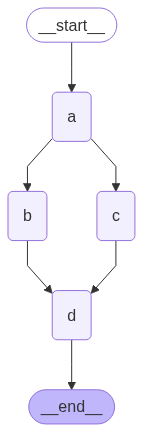

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API) #  使用 MermaidDrawMethod.API 指定使用 Mermaid.ink API 渲染
display(Image(png_bytes)) #  在 Notebook 中显示 PNG 图片

##### 示例 3-38：使用 Mermaid 和 Pyppeteer 库渲染 PNG 图片

In [ ]:
import random
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


class MyNode:
    def __init__(self, name: str):
        self.name = name

    def __call__(self, state: State):
        return {"messages": [("assistant", f"Called node {self.name}")]}


def route(state) -> Literal["entry_node", "__end__"]:
    if len(state["messages"]) > 10:
        return "__end__"
    return "entry_node"


def add_fractal_nodes(builder, current_node, level, max_level):
    if level > max_level:
        return

    # Number of nodes to create at this level
    num_nodes = random.randint(1, 3)  # Adjust randomness as needed
    for i in range(num_nodes):
        nm = ["A", "B", "C"][i]
        node_name = f"node_{current_node}_{nm}"
        builder.add_node(node_name, MyNode(node_name))
        builder.add_edge(current_node, node_name)

        # Recursively add more nodes
        r = random.random()
        if r > 0.2 and level + 1 < max_level:
            add_fractal_nodes(builder, node_name, level + 1, max_level)
        elif r > 0.05:
            builder.add_conditional_edges(node_name, route, node_name)
        else:
            # End
            builder.add_edge(node_name, "__end__")


def build_fractal_graph(max_level: int):
    builder = StateGraph(State)
    entry_point = "entry_node"
    builder.add_node(entry_point, MyNode(entry_point))
    builder.add_edge(START, entry_point)

    add_fractal_nodes(builder, entry_point, 1, max_level)

    # Optional: set a finish point if required
    builder.add_edge(entry_point, END)  # or any specific node

    return builder.compile()


app = build_fractal_graph(3)

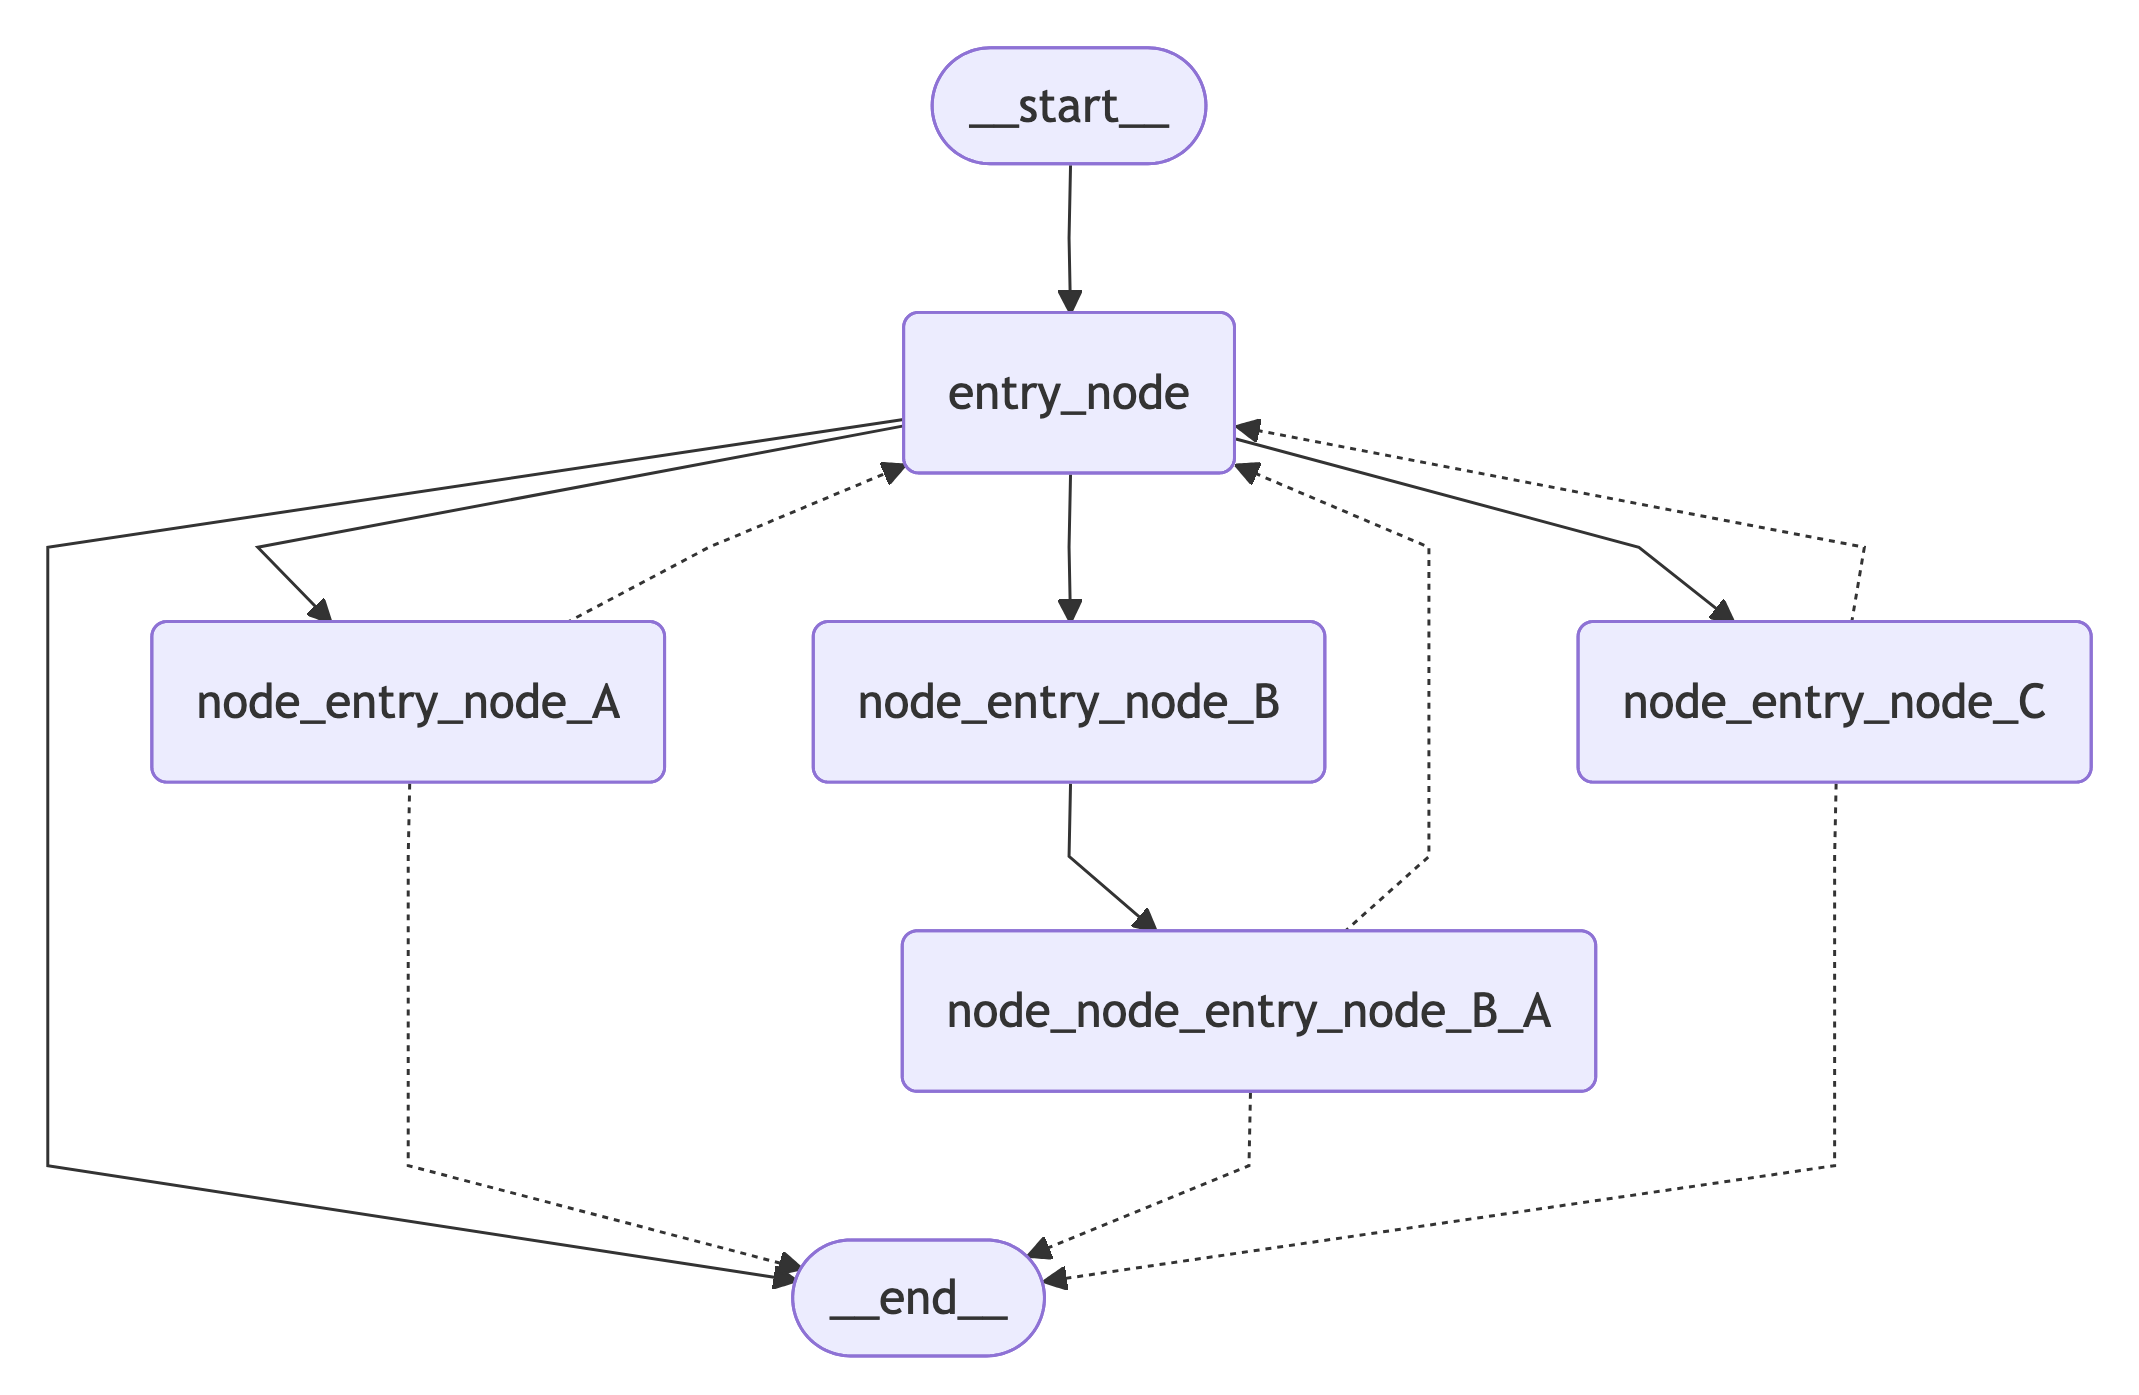

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
import nest_asyncio

# 修复 asyncio 运行时错误
nest_asyncio.apply()

png_bytes = app.get_graph().draw_mermaid_png( #  使用 draw_mermaid_png() 方法渲染 PNG 图片
    draw_method=MermaidDrawMethod.PYPPETEER, #  指定使用 MermaidDrawMethod.PYPPETEER,  使用 Mermaid + Pyppeteer 渲染
    curve_style=CurveStyle.LINEAR, #  设置曲线风格为线性
    node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"), #  自定义节点颜色
    wrap_label_n_words=9, #  设置节点标签自动换行，  每行最多 9 个单词
    output_file_path=None, #  不输出到文件
    background_color="white", #  设置背景色为白色
    padding=10, #  设置边距为 10 像素
)
display(Image(png_bytes)) #  在 Notebook 中显示 PNG 图片

**💡 图可视化核心价值**：

#### 可视化方式对比

| 方式 | 优点 | 缺点 | 适用场景 |
|------|------|------|----------|
| **Mermaid 语法** | 轻量级，无需依赖，跨平台 | 定制化选项有限 | 快速原型，文档嵌入 |
| **PNG 图片** | 直观清晰，易于分享 | 无法动态编辑 | 报告展示，静态文档 |
| **交互式图表** | 可交互，功能丰富 | 需要额外工具 | 复杂系统分析 |

#### 实际应用场景

- **开发阶段**：使用 Mermaid 快速验证流程逻辑
- **调试阶段**：通过图可视化发现流程问题
- **文档阶段**：生成图表用于技术文档和团队分享
- **维护阶段**：通过图结构分析优化系统架构

图可视化不仅是一个开发辅助工具，更是理解和优化 LangGraph 系统的重要手段，特别是在处理复杂的多智能体系统和子图嵌套场景时发挥重要作用。

## 📚 本章总结

通过本章的学习，我们深入探讨了 LangGraph 的图驱动 AI 智能体系统，掌握了状态、节点、边、命令四大核心原语的应用，学会了并行处理、MapReduce 模式、子图机制等高级技术，以及工具集成和图可视化等实用开发技能。LangGraph 的图计算模型为我们提供了构建复杂、动态、可扩展智能体系统的强大能力，让我们能够设计出真正适应现实世界复杂场景的 AI 应用。在下一章中，我们将探讨 AI 智能体的交互体验设计，学习如何构建更加人性化、直观易用的智能体界面和交互模式。